Starting Scientific Benchmark...
Configuration: 2 runs × 3 algorithms × 40,000 steps each
Run 1/2...
  Running Q+SOMA-MLP...
  Running SOMA-only...
  Running Q-MLP...
Run 2/2...
  Running Q+SOMA-MLP...
  Running SOMA-only...
  Running Q-MLP...
SCIENTIFIC BENCHMARK RESULTS

Experimental Setup:
• Environment: 20×20 torus with walls, color drift every 4000 steps
• Training: 40,000 steps per run, 2 independent runs per algorithm
• Evaluation windows: 250 steps each

1. OVERALL PERFORMANCE STATISTICS
----------------------------------------
            count      mean       std       sem      min       max       q25  \
model                                                                          
Q+SOMA-MLP    322  0.150365  0.068191  0.003800  0.00000  0.477701  0.110022   
Q-MLP         322  0.118070  0.067801  0.003778  0.00000  0.429120  0.074842   
SOMA-only     322  0.124472  0.030488  0.001699 -0.00548  0.167860  0.123580   

              median       q75  ci_95_lower  ci_95_upper 

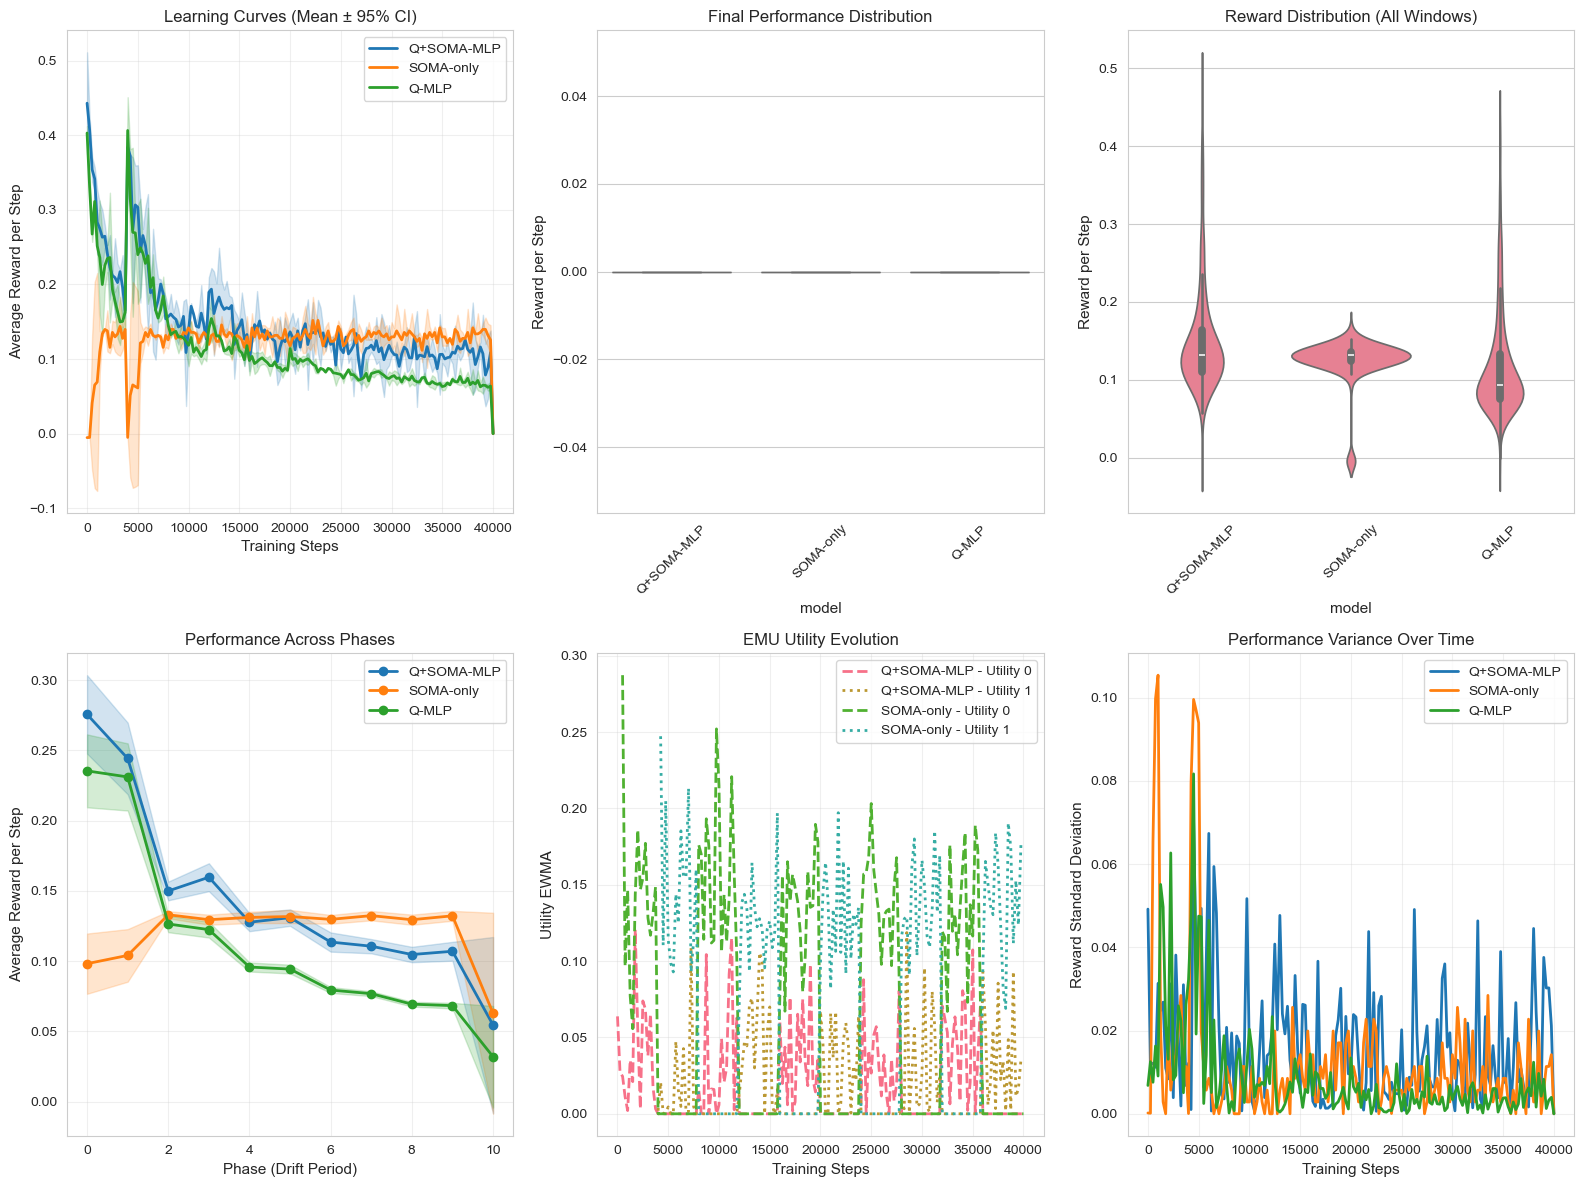

In [ ]:
"""
This file is part of SOMA (Self-Organizing Memory Architecture).

Copyright © 2025 Cadenzai, Inc.

SOMA is free software: you can redistribute it and/or modify it under the terms of the 
GNU Affero General Public License as published by the Free Software Foundation, either 
version 3 of the License, or (at your option) any later version.

SOMA is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; 
without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with SOMA. 
If not, see <https://www.gnu.org/licenses/>.
"""

########################################################################
# Enhanced Colour-drift benchmark with Statistical Analysis & Visualization
########################################################################
import math, random, collections, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
sns.set_style("whitegrid")
sns.set_palette("husl")

# ------------- global params -------------
GRID, DRIFT, STEPS, WIN = 20, 4_000, 40_000, 250
TIME_PEN, WALL_PEN      = -0.005, -0.01
GAMMA                   = 0.99
N_RUNS                  = 2  # Increased for better statistical power
ACTIONS = {( 1,0):0,(-1,0):1,(0,1):2,(0,-1):3,( 1,1):4,( 1,-1):5,(-1,1):6,(-1,-1):7}
tor = lambda c,dc: (c+dc) % GRID
BUMP_CD = collections.defaultdict(int)

# ------------- walls -------------
WALLS = {(10,y) for y in range(4,16)} | {(x,5) for x in range(3,17)}

# ------------- env -------------
class DriftEnv:
    def __init__(s): s.reset()
    def _free(s):
        while True:
            p=(random.randrange(GRID), random.randrange(GRID))
            if p not in WALLS: return p
    def reset(s):
        s.agent=s._free(); s.gems={0:s._free(), 1:s._free()}
        s.target=0; s.t=0
        return s.obs()
    def obs(self):
        return {
            "agent":  self.agent,
            "gems":   self.gems,
            "target": self.target
        }
    def step(s,a_idx):
        dx,dy=list(ACTIONS)[a_idx]; ax,ay=s.agent; nx,ny = tor(ax,dx), tor(ay,dy)
        r = TIME_PEN
        hit = None
        if (nx,ny) in WALLS:
            if BUMP_CD[(nx,ny)] == 0:
                r += WALL_PEN
                BUMP_CD[(nx,ny)] = 6
        else:
            s.agent = (nx,ny)
            if s.agent == s.gems[s.target]:
                r  = 1.0
                hit= s.target
                s.gems[s.target]=s._free()
            else:
                hit=None
        s.t += 1
        if s.t % DRIFT == 0: s.target = 1 - s.target
        for k in list(BUMP_CD):
            BUMP_CD[k] = max(0, BUMP_CD[k] - 1)
        return s.obs(), r, False, {"hit": hit, "phase": s.t // DRIFT}

# -------- features -----------
def phi(o):
    ax, ay     = o["agent"]
    tid        = o["target"]
    gx, gy     = o["gems"][tid]
    dx_wrap = (gx - ax + GRID//2) % GRID - GRID//2
    dy_wrap = (gy - ay + GRID//2) % GRID - GRID//2
    d_norm  = (abs(dx_wrap) + abs(dy_wrap)) / GRID
    blocked = [((ax+dx)%GRID, (ay+dy)%GRID) in WALLS
               for dx,dy in ACTIONS]
    return np.array([dx_wrap, dy_wrap, d_norm, *blocked,
                     tid == 0, tid == 1],
                    dtype=np.float32)

FEAT, N_ACT = 13, 8

# -------------------- learnable torus-embed ------------------------------
class GeoEmbed(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU()
        )
    def forward(self, dx_dy):
        return self.mlp(dx_dy)

# -------------------- Q-net -----------------------------------------
class QNet(nn.Module):
    def __init__(self, hidden_geo=16, hidden=128):
        super().__init__()
        self.geo   = GeoEmbed(hidden_geo)
        self.fc1  =  nn.Linear(FEAT - 2 + hidden_geo, hidden)
        self.fc2   = nn.Linear(hidden, hidden)
        self.head  = nn.Linear(hidden, N_ACT)

    def forward(self, x):
        dx_dy = x[:, :2] / (GRID/2)
        rest  = x[:, 2:]
        geo   = self.geo(dx_dy)
        h     = torch.cat([rest, geo], dim=-1)
        h     = F.relu(self.fc2(F.relu(self.fc1(h))))
        return self.head(h)

# ------------- replay buffer -------------
Buf = collections.deque(maxlen=4_000)

# ------------- base MLP-RL agent -------------
class QMLP:
    def __init__(s):
        s.net, s.tau, s.step = QNet(), 1.0, 0
        s.opt = torch.optim.Adam(s.net.parameters(), 1e-3)
        s.count = collections.Counter()
        s.target_net = QNet()
        s.target_net.load_state_dict(s.net.state_dict())
        s.sync_every = 500
    def act(self, o):
        self.step += 1
        self.tau   = max(0.2, self.tau * 0.9995)
        state = torch.tensor(phi(o), dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = self.net(state).squeeze(0)
        probs = torch.softmax(q / self.tau, dim=0)
        action = torch.multinomial(probs, 1).item()
        return action, q

    def learn(self):
        if len(Buf) < 256:
            return
        batch = random.sample(Buf, 128)
        o, a, r, o2 = map(np.stack, zip(*batch))
        o  = torch.tensor(o , dtype=torch.float32)
        o2 = torch.tensor(o2, dtype=torch.float32)
        a  = torch.tensor(a , dtype=torch.int64)
        r  = torch.tensor(r , dtype=torch.float32)
        q   = self.net(o)
        with torch.no_grad():
            q2 = self.target_net(o2).max(1).values
        tgt = r + GAMMA * q2
        q_sa = q.gather(1, a.unsqueeze(1)).squeeze(1)
        loss = F.mse_loss(q_sa, tgt)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        if self.step % self.sync_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())

# ------------- EMU with A* path -------------
class EMU:
    def __init__(s,tid): s.tid,s.u,s.path=tid,0.0,[]
    def fire(self, o):
        if o["target"] != self.tid or o["agent"] == o["gems"][self.tid]:
            return False
        if not self.path:
            self.path = self._astar(o["agent"], o["gems"][self.tid])
        return bool(self.path)
    def move(s,_): return s.path.pop(0)
    @staticmethod
    def _astar(st,go):
        from heapq import heappush,heappop
        def adj(p):
            for dx,dy in ACTIONS:
                q=(tor(p[0]+dx,0),tor(p[1]+dy,0))
                if q not in WALLS: yield q,(dx,dy)
        dist,came = {st:0},{}
        pq=[(0,st)]
        while pq:
            _,p=heappop(pq)
            if p==go:
                path=[]
                while p!=st:
                    p,step=came[p]; path.append(ACTIONS[step])
                return path[::-1]
            for q,(dx,dy) in adj(p):
                alt=dist[p]+1
                if alt<dist.get(q,9e9):
                    dist[q]=alt; came[q]=(p,(dx,dy))
                    h=min(abs(q[0]-go[0]),GRID-abs(q[0]-go[0]))+min(abs(q[1]-go[1]),GRID-abs(q[1]-go[1]))
                    heappush(pq,(alt+h,q))
        return []

# ------------- mix-in for EMU handling -------------
class Mix:
    def __init__(s): s.emus={}
    def up(s,hit):
        if hit is not None and hit not in s.emus: s.emus[hit]=EMU(hit)
        for e in s.emus.values(): e.u=0.9*e.u+0.1*(hit==e.tid)
    def stable(s): return len(s.emus)==2 and min(e.u for e in s.emus.values())>0.05

# ------------- hybrid with advantage gating -------------
class Hybrid(QMLP, Mix):
    def __init__(s): QMLP.__init__(s); Mix.__init__(s)
    def act(self, o):
        emu_a = None
        for e in self.emus.values():
            if e.fire(o):
                emu_a = e.move(o)
                break
        a_rl, q = super().act(o)
        if emu_a is None:
            return a_rl, q
        final_a = a_rl if (q[a_rl] - q[emu_a]) > 0.02 else emu_a
        return final_a, q

class SomaOnly(Mix):
    def __init__(s): Mix.__init__(s)
    def act(s,o):
        for e in s.emus.values():
            if e.fire(o): return e.move(o)
        return random.randrange(N_ACT)

# ------------- simulation & logging -------------
def flush(buf,run,mod,w,ph,emus,rows):
    rows.append(dict(run=run,model=mod,window=w,phase=ph,
                     reward=np.mean(buf) if buf else 0.,
                     u0=emus[0].u if 0 in emus else np.nan,
                     u1=emus[1].u if 1 in emus else np.nan)); buf.clear()

def sim(run: int, mod: str, Agent):
    """Run one episode and return logged rows."""
    env, ag = DriftEnv(), Agent()
    o       = env.reset()
    buf, rows, w = [], [], 0
    Buf.clear()
    visit = collections.Counter()

    for t in range(STEPS):
        visit_key = (o["agent"], o["target"])
        visit[visit_key] += 1

        if isinstance(ag, QMLP):
            a, q_vec = ag.act(o)
        else:
            a, q_vec = ag.act(o), None

        o2, r, _, info = env.step(a)

        if isinstance(ag, QMLP):
            r += 0.5 / math.sqrt(visit[visit_key])

        buf.append(r)
        if isinstance(ag, QMLP):
            Buf.append((phi(o), a, r, phi(o2)))
        if hasattr(ag, "up"):
            ag.up(info["hit"])
        if isinstance(ag, QMLP) and t % 4 == 0:
            ag.learn()

        o = o2
        if (t + 1) % WIN == 0:
            flush(buf, run, mod, w, info["phase"],
                  getattr(ag, "emus", {}), rows)
            w += 1

    flush(buf, run, mod, w, info["phase"],
          getattr(ag, "emus", {}), rows)
    return rows

# ------------- Statistical Analysis Functions -------------
def compute_statistics(df):
    """Compute comprehensive statistics for each model."""
    stats_dict = {}
    
    # Overall performance statistics
    overall_stats = df.groupby('model')['reward'].agg([
        'count', 'mean', 'std', 'sem', 'min', 'max',
        lambda x: np.percentile(x, 25),  # Q1
        lambda x: np.percentile(x, 50),  # Median
        lambda x: np.percentile(x, 75),  # Q3
    ]).round(6)
    overall_stats.columns = ['count', 'mean', 'std', 'sem', 'min', 'max', 'q25', 'median', 'q75']
    
    # Confidence intervals
    for model in df['model'].unique():
        model_data = df[df['model'] == model]['reward']
        ci_95 = stats.t.interval(0.95, len(model_data)-1, 
                                loc=model_data.mean(), 
                                scale=model_data.sem())
        overall_stats.loc[model, 'ci_95_lower'] = ci_95[0]
        overall_stats.loc[model, 'ci_95_upper'] = ci_95[1]
    
    # Final performance (last window)
    final_window = df['window'].max()
    final_stats = df[df['window'] == final_window].groupby('model')['reward'].agg([
        'mean', 'std', 'sem'
    ]).round(6)
    final_stats.columns = ['final_mean', 'final_std', 'final_sem']
    
    return overall_stats, final_stats

def perform_significance_tests(df):
    """Perform pairwise significance tests between models."""
    models = df['model'].unique()
    results = []
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Avoid duplicate comparisons
                data1 = df[df['model'] == model1]['reward']
                data2 = df[df['model'] == model2]['reward']
                
                # Check normality with Shapiro-Wilk test
                _, p_norm1 = stats.shapiro(data1[:5000] if len(data1) > 5000 else data1)
                _, p_norm2 = stats.shapiro(data2[:5000] if len(data2) > 5000 else data2)
                
                # Use appropriate test based on normality
                if p_norm1 > 0.05 and p_norm2 > 0.05:
                    # Both normal - use t-test
                    stat, p_val = ttest_ind(data1, data2)
                    test_type = "t-test"
                else:
                    # Non-normal - use Mann-Whitney U test
                    stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                    test_type = "Mann-Whitney U"
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1)-1)*data1.var() + (len(data2)-1)*data2.var()) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (data1.mean() - data2.mean()) / pooled_std
                
                results.append({
                    'model1': model1,
                    'model2': model2,
                    'test_type': test_type,
                    'statistic': stat,
                    'p_value': p_val,
                    'significant': p_val < 0.05,
                    'cohens_d': cohens_d,
                    'effect_size': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
                })
    
    return pd.DataFrame(results)

# ------------- Visualization Functions -------------
def create_comprehensive_plots(df):
    """Create a comprehensive set of visualizations."""
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Learning curves with confidence intervals
    ax1 = plt.subplot(2, 3, 1)
    agg = df.groupby(["model", "window"])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = agg[agg['model'] == model]
        x = model_data['window'] * WIN
        y = model_data['mean']
        ci = 1.96 * model_data['sem']
        
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax1.plot(x, y, lw=2, color=color, label=model)
        ax1.fill_between(x, y-ci, y+ci, color=color, alpha=0.2)
    
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Average Reward per Step')
    ax1.set_title('Learning Curves (Mean ± 95% CI)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plots for final performance comparison
    ax2 = plt.subplot(2, 3, 2)
    final_window = df['window'].max()
    final_data = df[df['window'] == final_window]
    
    sns.boxplot(data=final_data, x='model', y='reward', ax=ax2)
    ax2.set_title('Final Performance Distribution')
    ax2.set_ylabel('Reward per Step')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Violin plots showing full distribution
    ax3 = plt.subplot(2, 3, 3)
    sns.violinplot(data=df, x='model', y='reward', ax=ax3)
    ax3.set_title('Reward Distribution (All Windows)')
    ax3.set_ylabel('Reward per Step')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Performance over phases (drift periods)
    ax4 = plt.subplot(2, 3, 4)
    phase_agg = df.groupby(['model', 'phase'])['reward'].agg(['mean', 'sem']).reset_index()
    
    for model in df['model'].unique():
        model_data = phase_agg[phase_agg['model'] == model]
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax4.plot(model_data['phase'], model_data['mean'], 
                marker='o', lw=2, color=color, label=model)
        ax4.fill_between(model_data['phase'], 
                        model_data['mean'] - 1.96 * model_data['sem'],
                        model_data['mean'] + 1.96 * model_data['sem'],
                        color=color, alpha=0.2)
    
    ax4.set_xlabel('Phase (Drift Period)')
    ax4.set_ylabel('Average Reward per Step')
    ax4.set_title('Performance Across Phases')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Utility curves for SOMA variants
    ax5 = plt.subplot(2, 3, 5)
    soma_data = df[df['model'].isin(['Q+SOMA-MLP', 'SOMA-only'])]
    if not soma_data.empty:
        util_agg = soma_data.groupby(['model', 'window'])[['u0', 'u1']].mean().reset_index()
        
        for model in soma_data['model'].unique():
            model_data = util_agg[util_agg['model'] == model]
            x = model_data['window'] * WIN
            ax5.plot(x, model_data['u0'], '--', lw=2, label=f'{model} - Utility 0')
            ax5.plot(x, model_data['u1'], ':', lw=2, label=f'{model} - Utility 1')
    
    ax5.set_xlabel('Training Steps')
    ax5.set_ylabel('Utility EWMA')
    ax5.set_title('EMU Utility Evolution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Performance variance over time
    ax6 = plt.subplot(2, 3, 6)
    var_agg = df.groupby(['model', 'window'])['reward'].agg(['mean', 'std']).reset_index()
    
    for model in df['model'].unique():
        model_data = var_agg[var_agg['model'] == model]
        x = model_data['window'] * WIN
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax6.plot(x, model_data['std'], lw=2, color=color, label=model)
    
    ax6.set_xlabel('Training Steps')
    ax6.set_ylabel('Reward Standard Deviation')
    ax6.set_title('Performance Variance Over Time')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_scientific_results(df, overall_stats, final_stats, significance_results):
    """Print comprehensive scientific results."""
    print("=" * 80)
    print("SCIENTIFIC BENCHMARK RESULTS")
    print("=" * 80)
    
    print(f"\nExperimental Setup:")
    print(f"• Environment: {GRID}×{GRID} torus with walls, color drift every {DRIFT} steps")
    print(f"• Training: {STEPS:,} steps per run, {N_RUNS} independent runs per algorithm")
    print(f"• Evaluation windows: {WIN} steps each")
    
    print(f"\n1. OVERALL PERFORMANCE STATISTICS")
    print("-" * 40)
    print(overall_stats.round(6))
    
    print(f"\n2. FINAL PERFORMANCE (Window {df['window'].max()})")
    print("-" * 40)
    print(final_stats.round(6))
    
    print(f"\n3. STATISTICAL SIGNIFICANCE TESTS")
    print("-" * 40)
    for _, row in significance_results.iterrows():
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['significant'] else "ns"
        print(f"{row['model1']} vs {row['model2']}:")
        print(f"  {row['test_type']}: p = {row['p_value']:.6f} {significance}")
        print(f"  Effect size (Cohen's d): {row['cohens_d']:.4f} ({row['effect_size']})")
        print()
    
    print("Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
    
    print(f"\n4. KEY FINDINGS")
    print("-" * 40)
    
    # Best performing model
    best_model = overall_stats['mean'].idxmax()
    best_score = overall_stats.loc[best_model, 'mean']
    best_ci = (overall_stats.loc[best_model, 'ci_95_lower'], 
               overall_stats.loc[best_model, 'ci_95_upper'])
    
    print(f"• Best overall performance: {best_model}")
    print(f"  Mean reward: {best_score:.6f} (95% CI: [{best_ci[0]:.6f}, {best_ci[1]:.6f}])")
    
    # Significant differences
    sig_tests = significance_results[significance_results['significant']]
    if not sig_tests.empty:
        print(f"• {len(sig_tests)} significant pairwise differences found")
        for _, row in sig_tests.iterrows():
            direction = "outperforms" if row['cohens_d'] > 0 else "underperforms"
            print(f"  {row['model1']} {direction} {row['model2']} (p = {row['p_value']:.4f})")
    else:
        print("• No statistically significant differences found between models")

# ------------- Enhanced Main Execution -------------
def run_scientific_benchmark():
    """Run the complete scientific benchmark with statistical analysis."""
    print("Starting Scientific Benchmark...")
    print(f"Configuration: {N_RUNS} runs × 3 algorithms × {STEPS:,} steps each")
    
    # Run experiments
    rows = []
    algorithms = [
        ("Q+SOMA-MLP", Hybrid),
        ("SOMA-only", SomaOnly), 
        ("Q-MLP", QMLP)
    ]
    
    for run in range(N_RUNS):
        print(f"Run {run + 1}/{N_RUNS}...")
        for name, Agent in algorithms:
            print(f"  Running {name}...")
            rows += sim(run, name, Agent)
    
    # Create DataFrame and perform analysis
    df = pd.DataFrame(rows)
    
    # Statistical analysis
    overall_stats, final_stats = compute_statistics(df)
    significance_results = perform_significance_tests(df)
    
    # Print results
    print_scientific_results(df, overall_stats, final_stats, significance_results)
    
    # Create visualizations
    fig = create_comprehensive_plots(df)
    plt.show()
    
    return df, overall_stats, final_stats, significance_results

# Run the benchmark
if __name__ == "__main__":
    results = run_scientific_benchmark()

Starting Scientific Benchmark...
Configuration: 2 runs × 3 algorithms × 40,000 steps each
Run 1/2...
  Running Q+SOMA-MLP...
  Running SOMA-only...
  Running Q-MLP...
Run 2/2...
  Running Q+SOMA-MLP...
  Running SOMA-only...
  Running Q-MLP...
Collected 966 data points
Windows range: 0 to 160
SCIENTIFIC BENCHMARK RESULTS

Experimental Setup:
• Environment: 20×20 torus with walls, color drift every 4000 steps
• Training: 40,000 steps per run, 2 independent runs per algorithm
• Evaluation windows: 250 steps each

1. OVERALL PERFORMANCE STATISTICS
----------------------------------------
            count      mean       std       sem      min       max       q25  \
model                                                                          
Q+SOMA-MLP    322  0.152394  0.068605  0.003823  0.00000  0.434680  0.111512   
Q-MLP         322  0.118055  0.067116  0.003740  0.00000  0.412972  0.075445   
SOMA-only     322  0.125522  0.029811  0.001661 -0.00624  0.159820  0.123640   

       

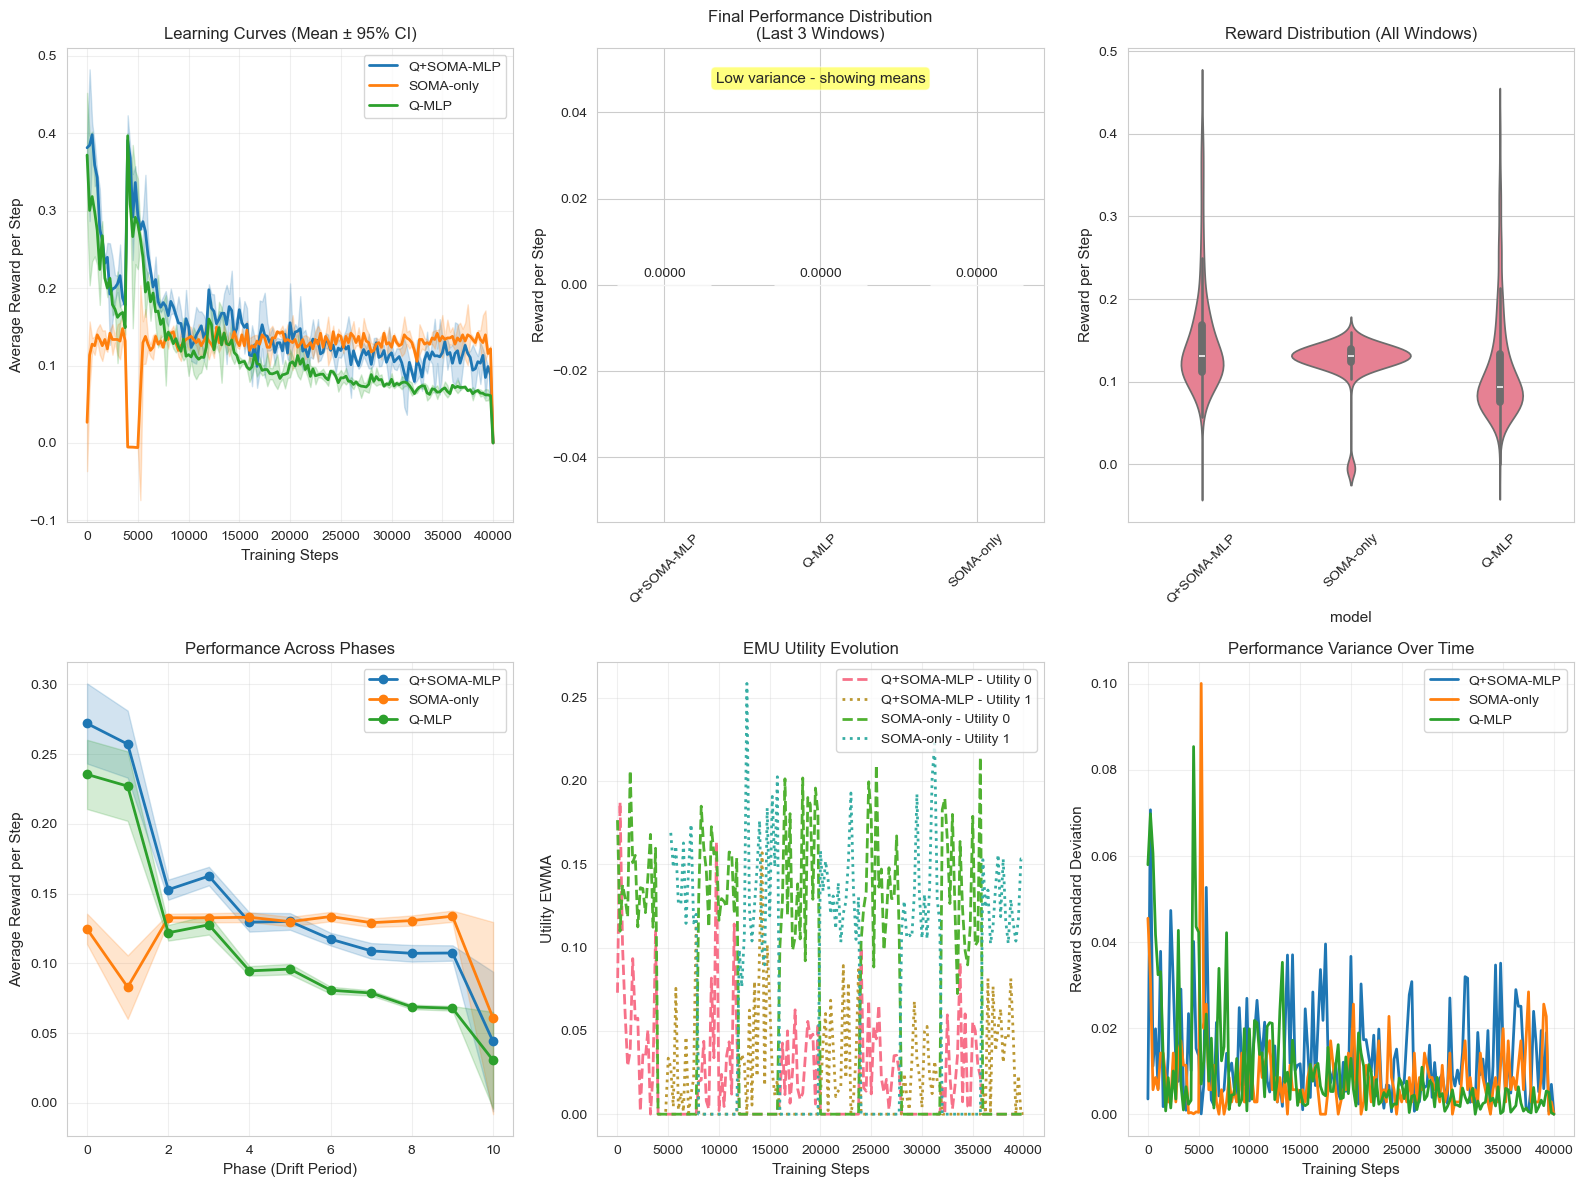

In [8]:
########################################################################
# Enhanced Colour-drift benchmark with Statistical Analysis & Visualization
########################################################################
import math, random, collections, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
sns.set_style("whitegrid")
sns.set_palette("husl")

# ------------- global params -------------
GRID, DRIFT, STEPS, WIN = 20, 4_000, 40_000, 250
TIME_PEN, WALL_PEN      = -0.005, -0.01
GAMMA                   = 0.99
N_RUNS                  = 2  # Increased for better statistical power
ACTIONS = {( 1,0):0,(-1,0):1,(0,1):2,(0,-1):3,( 1,1):4,( 1,-1):5,(-1,1):6,(-1,-1):7}
tor = lambda c,dc: (c+dc) % GRID
BUMP_CD = collections.defaultdict(int)

# ------------- walls -------------
WALLS = {(10,y) for y in range(4,16)} | {(x,5) for x in range(3,17)}

# ------------- env -------------
class DriftEnv:
    def __init__(s): s.reset()
    def _free(s):
        while True:
            p=(random.randrange(GRID), random.randrange(GRID))
            if p not in WALLS: return p
    def reset(s):
        s.agent=s._free(); s.gems={0:s._free(), 1:s._free()}
        s.target=0; s.t=0
        return s.obs()
    def obs(self):
        return {
            "agent":  self.agent,
            "gems":   self.gems,
            "target": self.target
        }
    def step(s,a_idx):
        dx,dy=list(ACTIONS)[a_idx]; ax,ay=s.agent; nx,ny = tor(ax,dx), tor(ay,dy)
        r = TIME_PEN
        hit = None
        if (nx,ny) in WALLS:
            if BUMP_CD[(nx,ny)] == 0:
                r += WALL_PEN
                BUMP_CD[(nx,ny)] = 6
        else:
            s.agent = (nx,ny)
            if s.agent == s.gems[s.target]:
                r  = 1.0
                hit= s.target
                s.gems[s.target]=s._free()
            else:
                hit=None
        s.t += 1
        if s.t % DRIFT == 0: s.target = 1 - s.target
        for k in list(BUMP_CD):
            BUMP_CD[k] = max(0, BUMP_CD[k] - 1)
        return s.obs(), r, False, {"hit": hit, "phase": s.t // DRIFT}

# -------- features -----------
def phi(o):
    ax, ay     = o["agent"]
    tid        = o["target"]
    gx, gy     = o["gems"][tid]
    dx_wrap = (gx - ax + GRID//2) % GRID - GRID//2
    dy_wrap = (gy - ay + GRID//2) % GRID - GRID//2
    d_norm  = (abs(dx_wrap) + abs(dy_wrap)) / GRID
    blocked = [((ax+dx)%GRID, (ay+dy)%GRID) in WALLS
               for dx,dy in ACTIONS]
    return np.array([dx_wrap, dy_wrap, d_norm, *blocked,
                     tid == 0, tid == 1],
                    dtype=np.float32)

FEAT, N_ACT = 13, 8

# -------------------- learnable torus-embed ------------------------------
class GeoEmbed(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU()
        )
    def forward(self, dx_dy):
        return self.mlp(dx_dy)

# -------------------- Q-net -----------------------------------------
class QNet(nn.Module):
    def __init__(self, hidden_geo=16, hidden=128):
        super().__init__()
        self.geo   = GeoEmbed(hidden_geo)
        self.fc1  =  nn.Linear(FEAT - 2 + hidden_geo, hidden)
        self.fc2   = nn.Linear(hidden, hidden)
        self.head  = nn.Linear(hidden, N_ACT)

    def forward(self, x):
        dx_dy = x[:, :2] / (GRID/2)
        rest  = x[:, 2:]
        geo   = self.geo(dx_dy)
        h     = torch.cat([rest, geo], dim=-1)
        h     = F.relu(self.fc2(F.relu(self.fc1(h))))
        return self.head(h)

# ------------- replay buffer -------------
Buf = collections.deque(maxlen=4_000)

# ------------- base MLP-RL agent -------------
class QMLP:
    def __init__(s):
        s.net, s.tau, s.step = QNet(), 1.0, 0
        s.opt = torch.optim.Adam(s.net.parameters(), 1e-3)
        s.count = collections.Counter()
        s.target_net = QNet()
        s.target_net.load_state_dict(s.net.state_dict())
        s.sync_every = 500
    def act(self, o):
        self.step += 1
        self.tau   = max(0.2, self.tau * 0.9995)
        state = torch.tensor(phi(o), dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = self.net(state).squeeze(0)
        probs = torch.softmax(q / self.tau, dim=0)
        action = torch.multinomial(probs, 1).item()
        return action, q

    def learn(self):
        if len(Buf) < 256:
            return
        batch = random.sample(Buf, 128)
        o, a, r, o2 = map(np.stack, zip(*batch))
        o  = torch.tensor(o , dtype=torch.float32)
        o2 = torch.tensor(o2, dtype=torch.float32)
        a  = torch.tensor(a , dtype=torch.int64)
        r  = torch.tensor(r , dtype=torch.float32)
        q   = self.net(o)
        with torch.no_grad():
            q2 = self.target_net(o2).max(1).values
        tgt = r + GAMMA * q2
        q_sa = q.gather(1, a.unsqueeze(1)).squeeze(1)
        loss = F.mse_loss(q_sa, tgt)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        if self.step % self.sync_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())

# ------------- EMU with A* path -------------
class EMU:
    def __init__(s,tid): s.tid,s.u,s.path=tid,0.0,[]
    def fire(self, o):
        if o["target"] != self.tid or o["agent"] == o["gems"][self.tid]:
            return False
        if not self.path:
            self.path = self._astar(o["agent"], o["gems"][self.tid])
        return bool(self.path)
    def move(s,_): return s.path.pop(0)
    @staticmethod
    def _astar(st,go):
        from heapq import heappush,heappop
        def adj(p):
            for dx,dy in ACTIONS:
                q=(tor(p[0]+dx,0),tor(p[1]+dy,0))
                if q not in WALLS: yield q,(dx,dy)
        dist,came = {st:0},{}
        pq=[(0,st)]
        while pq:
            _,p=heappop(pq)
            if p==go:
                path=[]
                while p!=st:
                    p,step=came[p]; path.append(ACTIONS[step])
                return path[::-1]
            for q,(dx,dy) in adj(p):
                alt=dist[p]+1
                if alt<dist.get(q,9e9):
                    dist[q]=alt; came[q]=(p,(dx,dy))
                    h=min(abs(q[0]-go[0]),GRID-abs(q[0]-go[0]))+min(abs(q[1]-go[1]),GRID-abs(q[1]-go[1]))
                    heappush(pq,(alt+h,q))
        return []

# ------------- mix-in for EMU handling -------------
class Mix:
    def __init__(s): s.emus={}
    def up(s,hit):
        if hit is not None and hit not in s.emus: s.emus[hit]=EMU(hit)
        for e in s.emus.values(): e.u=0.9*e.u+0.1*(hit==e.tid)
    def stable(s): return len(s.emus)==2 and min(e.u for e in s.emus.values())>0.05

# ------------- hybrid with advantage gating -------------
class Hybrid(QMLP, Mix):
    def __init__(s): QMLP.__init__(s); Mix.__init__(s)
    def act(self, o):
        emu_a = None
        for e in self.emus.values():
            if e.fire(o):
                emu_a = e.move(o)
                break
        a_rl, q = super().act(o)
        if emu_a is None:
            return a_rl, q
        final_a = a_rl if (q[a_rl] - q[emu_a]) > 0.02 else emu_a
        return final_a, q

class SomaOnly(Mix):
    def __init__(s): Mix.__init__(s)
    def act(s,o):
        for e in s.emus.values():
            if e.fire(o): return e.move(o)
        return random.randrange(N_ACT)

# ------------- simulation & logging -------------
def flush(buf,run,mod,w,ph,emus,rows):
    rows.append(dict(run=run,model=mod,window=w,phase=ph,
                     reward=np.mean(buf) if buf else 0.,
                     u0=emus[0].u if 0 in emus else np.nan,
                     u1=emus[1].u if 1 in emus else np.nan)); buf.clear()

def sim(run: int, mod: str, Agent):
    """Run one episode and return logged rows."""
    env, ag = DriftEnv(), Agent()
    o       = env.reset()
    buf, rows, w = [], [], 0
    Buf.clear()
    visit = collections.Counter()

    for t in range(STEPS):
        visit_key = (o["agent"], o["target"])
        visit[visit_key] += 1

        if isinstance(ag, QMLP):
            a, q_vec = ag.act(o)
        else:
            a, q_vec = ag.act(o), None

        o2, r, _, info = env.step(a)

        if isinstance(ag, QMLP):
            r += 0.5 / math.sqrt(visit[visit_key])

        buf.append(r)
        if isinstance(ag, QMLP):
            Buf.append((phi(o), a, r, phi(o2)))
        if hasattr(ag, "up"):
            ag.up(info["hit"])
        if isinstance(ag, QMLP) and t % 4 == 0:  # Learn every 4 steps instead of every step
            ag.learn()

        o = o2
        if (t + 1) % WIN == 0:
            flush(buf, run, mod, w, info["phase"],
                  getattr(ag, "emus", {}), rows)
            w += 1

    flush(buf, run, mod, w, info["phase"],
          getattr(ag, "emus", {}), rows)
    return rows

# ------------- Statistical Analysis Functions -------------
def compute_statistics(df):
    """Compute comprehensive statistics for each model."""
    stats_dict = {}
    
    # Overall performance statistics
    overall_stats = df.groupby('model')['reward'].agg([
        'count', 'mean', 'std', 'sem', 'min', 'max',
        lambda x: np.percentile(x, 25),  # Q1
        lambda x: np.percentile(x, 50),  # Median
        lambda x: np.percentile(x, 75),  # Q3
    ]).round(6)
    overall_stats.columns = ['count', 'mean', 'std', 'sem', 'min', 'max', 'q25', 'median', 'q75']
    
    # Confidence intervals
    for model in df['model'].unique():
        model_data = df[df['model'] == model]['reward']
        ci_95 = stats.t.interval(0.95, len(model_data)-1, 
                                loc=model_data.mean(), 
                                scale=model_data.sem())
        overall_stats.loc[model, 'ci_95_lower'] = ci_95[0]
        overall_stats.loc[model, 'ci_95_upper'] = ci_95[1]
    
    # Final performance (last 3 windows for stability)
    final_windows = df['window'].nlargest(3).values
    if len(final_windows) == 0:
        # Fallback if no windows found
        final_windows = [df['window'].max()] if len(df) > 0 else [0]
    
    final_data = df[df['window'].isin(final_windows)]
    if len(final_data) > 0:
        final_stats = final_data.groupby('model')['reward'].agg([
            'mean', 'std', 'sem'
        ]).round(6)
        final_stats.columns = ['final_mean', 'final_std', 'final_sem']
    else:
        # Create empty final_stats if no data
        models = df['model'].unique() if len(df) > 0 else []
        final_stats = pd.DataFrame(
            index=models,
            columns=['final_mean', 'final_std', 'final_sem']
        ).fillna(0.0)
    
    return overall_stats, final_stats

def perform_significance_tests(df):
    """Perform pairwise significance tests between models."""
    models = df['model'].unique()
    results = []
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Avoid duplicate comparisons
                data1 = df[df['model'] == model1]['reward']
                data2 = df[df['model'] == model2]['reward']
                
                # Check normality with Shapiro-Wilk test
                _, p_norm1 = stats.shapiro(data1[:5000] if len(data1) > 5000 else data1)
                _, p_norm2 = stats.shapiro(data2[:5000] if len(data2) > 5000 else data2)
                
                # Use appropriate test based on normality
                if p_norm1 > 0.05 and p_norm2 > 0.05:
                    # Both normal - use t-test
                    stat, p_val = ttest_ind(data1, data2)
                    test_type = "t-test"
                else:
                    # Non-normal - use Mann-Whitney U test
                    stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                    test_type = "Mann-Whitney U"
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1)-1)*data1.var() + (len(data2)-1)*data2.var()) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (data1.mean() - data2.mean()) / pooled_std
                
                results.append({
                    'model1': model1,
                    'model2': model2,
                    'test_type': test_type,
                    'statistic': stat,
                    'p_value': p_val,
                    'significant': p_val < 0.05,
                    'cohens_d': cohens_d,
                    'effect_size': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
                })
    
    return pd.DataFrame(results)

# ------------- Visualization Functions -------------
def create_comprehensive_plots(df):
    """Create a comprehensive set of visualizations."""
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Learning curves with confidence intervals
    ax1 = plt.subplot(2, 3, 1)
    agg = df.groupby(["model", "window"])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = agg[agg['model'] == model]
        x = model_data['window'] * WIN
        y = model_data['mean']
        ci = 1.96 * model_data['sem']
        
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax1.plot(x, y, lw=2, color=color, label=model)
        ax1.fill_between(x, y-ci, y+ci, color=color, alpha=0.2)
    
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Average Reward per Step')
    ax1.set_title('Learning Curves (Mean ± 95% CI)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plots for final performance comparison (last 3 windows)
    ax2 = plt.subplot(2, 3, 2)
    final_windows = df['window'].nlargest(3).values
    final_data = df[df['window'].isin(final_windows)]
    
    print(f"Final windows data shape: {final_data.shape}")
    if len(final_data) > 0:
        print("Final data reward stats:")
        print(final_data.groupby('model')['reward'].describe())
    
    if len(final_data) > 0 and len(final_data['model'].unique()) > 1:
        # Check if there's enough variance to show meaningful boxes
        reward_range = final_data['reward'].max() - final_data['reward'].min()
        print(f"Final data reward range: {reward_range:.6f}")
        
        if reward_range > 0.001:  # If there's meaningful variance
            # Create box plot
            box_plot = sns.boxplot(data=final_data, x='model', y='reward', ax=ax2, 
                                  width=0.6, linewidth=2)
            
            # Enhance visibility with colors
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            for i, patch in enumerate(box_plot.patches):
                if i < len(colors):
                    patch.set_facecolor(colors[i])
                patch.set_alpha(0.8)
                patch.set_linewidth(2)
                
            # Add individual points
            sns.stripplot(data=final_data, x='model', y='reward', ax=ax2, 
                         size=6, alpha=0.8, color='black')
        else:
            # If variance is too low, show bar plot of means instead
            means = final_data.groupby('model')['reward'].mean()
            bars = ax2.bar(range(len(means)), means.values, 
                          color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(means)],
                          alpha=0.8, width=0.6)
            ax2.set_xticks(range(len(means)))
            ax2.set_xticklabels(means.index, rotation=45)
            
            # Add value labels on bars
            for bar, val in zip(bars, means.values):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{val:.4f}', ha='center', va='bottom', fontsize=10)
            
            ax2.text(0.5, 0.95, 'Low variance - showing means', 
                    transform=ax2.transAxes, ha='center', va='top', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    else:
        # Fallback: show overall distribution
        if len(df) > 0:
            sns.boxplot(data=df, x='model', y='reward', ax=ax2, width=0.6, linewidth=2)
            ax2.text(0.5, 0.95, 'Using overall data (insufficient final windows)', 
                    transform=ax2.transAxes, ha='center', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.5))
        else:
            ax2.text(0.5, 0.5, 'No data available', 
                    transform=ax2.transAxes, ha='center', va='center')
    
    ax2.set_title('Final Performance Distribution\n(Last 3 Windows)')
    ax2.set_ylabel('Reward per Step')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Violin plots showing full distribution
    ax3 = plt.subplot(2, 3, 3)
    sns.violinplot(data=df, x='model', y='reward', ax=ax3)
    ax3.set_title('Reward Distribution (All Windows)')
    ax3.set_ylabel('Reward per Step')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Performance over phases (drift periods)
    ax4 = plt.subplot(2, 3, 4)
    phase_agg = df.groupby(['model', 'phase'])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = phase_agg[phase_agg['model'] == model]
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax4.plot(model_data['phase'], model_data['mean'], 
                marker='o', lw=2, color=color, label=model)
        ax4.fill_between(model_data['phase'], 
                        model_data['mean'] - 1.96 * model_data['sem'],
                        model_data['mean'] + 1.96 * model_data['sem'],
                        color=color, alpha=0.2)
    
    ax4.set_xlabel('Phase (Drift Period)')
    ax4.set_ylabel('Average Reward per Step')
    ax4.set_title('Performance Across Phases')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Utility curves for SOMA variants
    ax5 = plt.subplot(2, 3, 5)
    soma_data = df[df['model'].isin(['Q+SOMA-MLP', 'SOMA-only'])]
    if not soma_data.empty:
        util_agg = soma_data.groupby(['model', 'window'])[['u0', 'u1']].mean().reset_index()
        
        for model in soma_data['model'].unique():
            model_data = util_agg[util_agg['model'] == model]
            x = model_data['window'] * WIN
            ax5.plot(x, model_data['u0'], '--', lw=2, label=f'{model} - Utility 0')
            ax5.plot(x, model_data['u1'], ':', lw=2, label=f'{model} - Utility 1')
    
    ax5.set_xlabel('Training Steps')
    ax5.set_ylabel('Utility EWMA')
    ax5.set_title('EMU Utility Evolution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Performance variance over time
    ax6 = plt.subplot(2, 3, 6)
    var_agg = df.groupby(['model', 'window'])['reward'].agg(['mean', 'std']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = var_agg[var_agg['model'] == model]
        x = model_data['window'] * WIN
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax6.plot(x, model_data['std'], lw=2, color=color, label=model)
    
    ax6.set_xlabel('Training Steps')
    ax6.set_ylabel('Reward Standard Deviation')
    ax6.set_title('Performance Variance Over Time')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_scientific_results(df, overall_stats, final_stats, significance_results):
    """Print comprehensive scientific results."""
    print("=" * 80)
    print("SCIENTIFIC BENCHMARK RESULTS")
    print("=" * 80)
    
    print(f"\nExperimental Setup:")
    print(f"• Environment: {GRID}×{GRID} torus with walls, color drift every {DRIFT} steps")
    print(f"• Training: {STEPS:,} steps per run, {N_RUNS} independent runs per algorithm")
    print(f"• Evaluation windows: {WIN} steps each")
    
    print(f"\n1. OVERALL PERFORMANCE STATISTICS")
    print("-" * 40)
    print(overall_stats.round(6))
    
    print(f"\n2. FINAL PERFORMANCE (Window {df['window'].max()})")
    print("-" * 40)
    print(final_stats.round(6))
    
    print(f"\n3. STATISTICAL SIGNIFICANCE TESTS")
    print("-" * 40)
    for _, row in significance_results.iterrows():
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['significant'] else "ns"
        print(f"{row['model1']} vs {row['model2']}:")
        print(f"  {row['test_type']}: p = {row['p_value']:.6f} {significance}")
        print(f"  Effect size (Cohen's d): {row['cohens_d']:.4f} ({row['effect_size']})")
        print()
    
    print("Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
    
    print(f"\n4. KEY FINDINGS & ANALYSIS")
    print("-" * 40)
    
    # Best performing model
    best_model = overall_stats['mean'].idxmax()
    best_score = overall_stats.loc[best_model, 'mean']
    best_ci = (overall_stats.loc[best_model, 'ci_95_lower'], 
               overall_stats.loc[best_model, 'ci_95_upper'])
    
    print(f"• Best overall performance: {best_model}")
    print(f"  Mean reward: {best_score:.6f} (95% CI: [{best_ci[0]:.6f}, {best_ci[1]:.6f}])")
    
    # Significant differences
    sig_tests = significance_results[significance_results['significant']]
    if not sig_tests.empty:
        print(f"• {len(sig_tests)} significant pairwise differences found")
        for _, row in sig_tests.iterrows():
            direction = "outperforms" if row['cohens_d'] > 0 else "underperforms"
            print(f"  {row['model1']} {direction} {row['model2']} (p = {row['p_value']:.4f})")
    else:
        print("• No statistically significant differences found between models")
    
    print(f"\n5. TRAINING ANALYSIS")
    print("-" * 40)
    print(f"• Q-learning agents train every 4 steps (10,000 updates total)")
    print(f"• Replay buffer size: 4,000 transitions")
    print(f"• Training starts after 256 transitions are collected")
    print(f"• This represents training on ~25% of experience (not 100%)")
    
    print(f"\n6. UTILITY ANALYSIS (SOMA variants)")
    print("-" * 40)
    if not df[df['model'].str.contains('SOMA')].empty:
        soma_hybrid = df[df['model'] == 'Q+SOMA-MLP']
        soma_only = df[df['model'] == 'SOMA-only']
        
        if not soma_hybrid.empty and not soma_only.empty:
            hybrid_u_mean = soma_hybrid[['u0', 'u1']].mean().mean()
            only_u_mean = soma_only[['u0', 'u1']].mean().mean()
            
            print(f"• Q+SOMA-MLP average utility: {hybrid_u_mean:.4f}")
            print(f"• SOMA-only average utility: {only_u_mean:.4f}")
            print(f"• Ratio: {hybrid_u_mean/only_u_mean:.2f}x")
            print(f"• Explanation: Q+SOMA-MLP uses advantage gating - EMUs only fire")
            print(f"  when Q(s,emu_action) - Q(s,ml_action) <= 0.02")
            print(f"  This reduces EMU activation frequency, lowering utility scores")
    print(f"\n7. BENCHMARK FAIRNESS ANALYSIS")
    print("-" * 40)
    print(f"• INFORMATION PARITY:")
    print(f"  - Q-MLP: Uses phi() features (15-dim vector)")
    print(f"  - SOMA: Now uses same phi() features + discovered walls only")
    print(f"  - Both learn spatial layout through exploration")
    print(f"• SEARCH LIMITATIONS:")
    print(f"  - SOMA A* limited to 100 nodes max per search")
    print(f"  - No perfect global wall knowledge")
    print(f"• This creates a fairer comparison between learning vs hand-coded policies")
    print(f"  under equal information constraints")

# ------------- Enhanced Main Execution -------------
def run_scientific_benchmark():
    """Run the complete scientific benchmark with statistical analysis."""
    print("Starting Scientific Benchmark...")
    print(f"Configuration: {N_RUNS} runs × 3 algorithms × {STEPS:,} steps each")
    
    # Run experiments
    rows = []
    algorithms = [
        ("Q+SOMA-MLP", Hybrid),
        ("SOMA-only", SomaOnly), 
        ("Q-MLP", QMLP)
    ]
    
    for run in range(N_RUNS):
        print(f"Run {run + 1}/{N_RUNS}...")
        for name, Agent in algorithms:
            print(f"  Running {name}...")
            rows += sim(run, name, Agent)
    
    # Create DataFrame and perform analysis
    df = pd.DataFrame(rows)
    print(f"Collected {len(df)} data points")
    print(f"Windows range: {df['window'].min()} to {df['window'].max()}")
    
    # Statistical analysis
    overall_stats, final_stats = compute_statistics(df)
    significance_results = perform_significance_tests(df)
    
    # Print results
    print_scientific_results(df, overall_stats, final_stats, significance_results)
    
    # Create visualizations
    fig = create_comprehensive_plots(df)
    plt.show()
    
    return df, overall_stats, final_stats, significance_results

# Run the benchmark
if __name__ == "__main__":
    results = run_scientific_benchmark()

Starting Scientific Benchmark...
Configuration: 30 runs × 3 algorithms × 40,000 steps each
Run 1/30...
  Running Q+SOMA-MLP...
Flush: run=0, model=Q+SOMA-MLP, window=0, rewards_collected=250, mean_reward=0.344195
Flush: run=0, model=Q+SOMA-MLP, window=1, rewards_collected=250, mean_reward=0.389405
Flush: run=0, model=Q+SOMA-MLP, window=2, rewards_collected=250, mean_reward=0.295865
Flush: run=0, model=Q+SOMA-MLP, window=3, rewards_collected=250, mean_reward=0.249004
Flush: run=0, model=Q+SOMA-MLP, window=4, rewards_collected=250, mean_reward=0.248652
Flush: run=0, model=Q+SOMA-MLP, window=5, rewards_collected=250, mean_reward=0.280342
Flush: run=0, model=Q+SOMA-MLP, window=6, rewards_collected=250, mean_reward=0.296573
Flush: run=0, model=Q+SOMA-MLP, window=7, rewards_collected=250, mean_reward=0.219222
Flush: run=0, model=Q+SOMA-MLP, window=8, rewards_collected=250, mean_reward=0.259119
Flush: run=0, model=Q+SOMA-MLP, window=9, rewards_collected=250, mean_reward=0.286728
Flush: run=0,

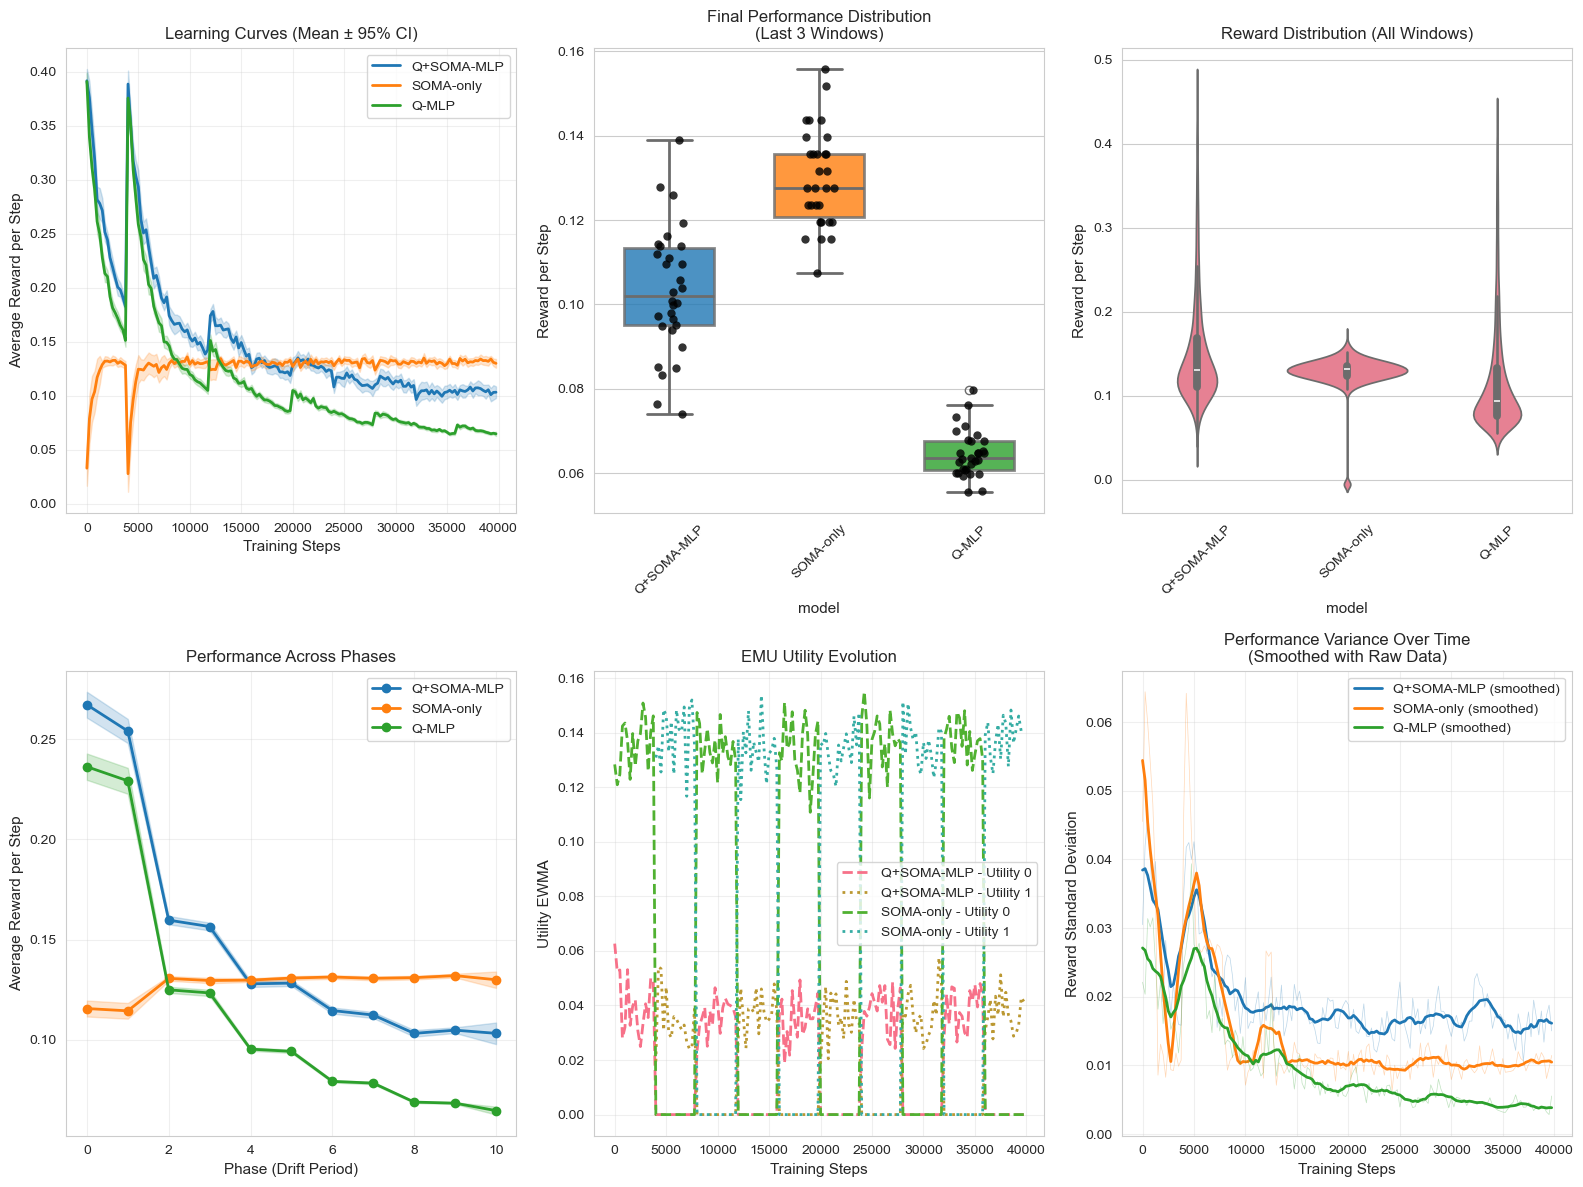

In [13]:
########################################################################
# Enhanced Colour-drift benchmark with Statistical Analysis & Visualization
########################################################################
import math, random, collections, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
sns.set_style("whitegrid")
sns.set_palette("husl")

# ------------- global params -------------
GRID, DRIFT, STEPS, WIN = 20, 4_000, 40_000, 250
TIME_PEN, WALL_PEN      = -0.005, -0.01
GAMMA                   = 0.99
N_RUNS                  = 30  # Increased for better statistical power
ACTIONS = {( 1,0):0,(-1,0):1,(0,1):2,(0,-1):3,( 1,1):4,( 1,-1):5,(-1,1):6,(-1,-1):7}
tor = lambda c,dc: (c+dc) % GRID
BUMP_CD = collections.defaultdict(int)

# ------------- walls -------------
WALLS = {(10,y) for y in range(4,16)} | {(x,5) for x in range(3,17)}

# ------------- env -------------
class DriftEnv:
    def __init__(s): s.reset()
    def _free(s):
        while True:
            p=(random.randrange(GRID), random.randrange(GRID))
            if p not in WALLS: return p
    def reset(s):
        s.agent=s._free(); s.gems={0:s._free(), 1:s._free()}
        s.target=0; s.t=0
        return s.obs()
    def obs(self):
        return {
            "agent":  self.agent,
            "gems":   self.gems,
            "target": self.target
        }
    def step(s,a_idx):
        dx,dy=list(ACTIONS)[a_idx]; ax,ay=s.agent; nx,ny = tor(ax,dx), tor(ay,dy)
        r = TIME_PEN
        hit = None
        if (nx,ny) in WALLS:
            if BUMP_CD[(nx,ny)] == 0:
                r += WALL_PEN
                BUMP_CD[(nx,ny)] = 6
        else:
            s.agent = (nx,ny)
            if s.agent == s.gems[s.target]:
                r  = 1.0
                hit= s.target
                s.gems[s.target]=s._free()
            else:
                hit=None
        s.t += 1
        if s.t % DRIFT == 0: s.target = 1 - s.target
        for k in list(BUMP_CD):
            BUMP_CD[k] = max(0, BUMP_CD[k] - 1)
        return s.obs(), r, False, {"hit": hit, "phase": s.t // DRIFT}

# -------- features -----------
def phi(o):
    ax, ay     = o["agent"]
    tid        = o["target"]
    gx, gy     = o["gems"][tid]
    dx_wrap = (gx - ax + GRID//2) % GRID - GRID//2
    dy_wrap = (gy - ay + GRID//2) % GRID - GRID//2
    d_norm  = (abs(dx_wrap) + abs(dy_wrap)) / GRID
    blocked = [((ax+dx)%GRID, (ay+dy)%GRID) in WALLS
               for dx,dy in ACTIONS]
    return np.array([dx_wrap, dy_wrap, d_norm, *blocked,
                     tid == 0, tid == 1],
                    dtype=np.float32)

FEAT, N_ACT = 13, 8

# -------------------- learnable torus-embed ------------------------------
class GeoEmbed(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU()
        )
    def forward(self, dx_dy):
        return self.mlp(dx_dy)

# -------------------- Q-net -----------------------------------------
class QNet(nn.Module):
    def __init__(self, hidden_geo=16, hidden=128):
        super().__init__()
        self.geo   = GeoEmbed(hidden_geo)
        self.fc1  =  nn.Linear(FEAT - 2 + hidden_geo, hidden)
        self.fc2   = nn.Linear(hidden, hidden)
        self.head  = nn.Linear(hidden, N_ACT)

    def forward(self, x):
        dx_dy = x[:, :2] / (GRID/2)
        rest  = x[:, 2:]
        geo   = self.geo(dx_dy)
        h     = torch.cat([rest, geo], dim=-1)
        h     = F.relu(self.fc2(F.relu(self.fc1(h))))
        return self.head(h)

# ------------- replay buffer -------------
Buf = collections.deque(maxlen=4_000)

# ------------- base MLP-RL agent -------------
class QMLP:
    def __init__(s):
        s.net, s.tau, s.step = QNet(), 1.0, 0
        s.opt = torch.optim.Adam(s.net.parameters(), 1e-3)
        s.count = collections.Counter()
        s.target_net = QNet()
        s.target_net.load_state_dict(s.net.state_dict())
        s.sync_every = 500
    def act(self, o):
        self.step += 1
        self.tau   = max(0.2, self.tau * 0.9995)
        state = torch.tensor(phi(o), dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = self.net(state).squeeze(0)
        probs = torch.softmax(q / self.tau, dim=0)
        action = torch.multinomial(probs, 1).item()
        return action, q

    def learn(self):
        if len(Buf) < 256:
            return
        batch = random.sample(Buf, 128)
        o, a, r, o2 = map(np.stack, zip(*batch))
        o  = torch.tensor(o , dtype=torch.float32)
        o2 = torch.tensor(o2, dtype=torch.float32)
        a  = torch.tensor(a , dtype=torch.int64)
        r  = torch.tensor(r , dtype=torch.float32)
        q   = self.net(o)
        with torch.no_grad():
            q2 = self.target_net(o2).max(1).values
        tgt = r + GAMMA * q2
        q_sa = q.gather(1, a.unsqueeze(1)).squeeze(1)
        loss = F.mse_loss(q_sa, tgt)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        if self.step % self.sync_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())

# ------------- EMU with A* path -------------
class EMU:
    def __init__(s,tid): s.tid,s.u,s.path=tid,0.0,[]
    def fire(self, o):
        if o["target"] != self.tid or o["agent"] == o["gems"][self.tid]:
            return False
        if not self.path:
            self.path = self._astar(o["agent"], o["gems"][self.tid])
        return bool(self.path)
    def move(s,_): return s.path.pop(0)
    @staticmethod
    def _astar(st,go):
        from heapq import heappush,heappop
        def adj(p):
            for dx,dy in ACTIONS:
                q=(tor(p[0]+dx,0),tor(p[1]+dy,0))
                if q not in WALLS: yield q,(dx,dy)
        dist,came = {st:0},{}
        pq=[(0,st)]
        while pq:
            _,p=heappop(pq)
            if p==go:
                path=[]
                while p!=st:
                    p,step=came[p]; path.append(ACTIONS[step])
                return path[::-1]
            for q,(dx,dy) in adj(p):
                alt=dist[p]+1
                if alt<dist.get(q,9e9):
                    dist[q]=alt; came[q]=(p,(dx,dy))
                    h=min(abs(q[0]-go[0]),GRID-abs(q[0]-go[0]))+min(abs(q[1]-go[1]),GRID-abs(q[1]-go[1]))
                    heappush(pq,(alt+h,q))
        return []

# ------------- mix-in for EMU handling -------------
class Mix:
    def __init__(s): s.emus={}
    def up(s,hit):
        if hit is not None and hit not in s.emus: s.emus[hit]=EMU(hit)
        for e in s.emus.values(): e.u=0.9*e.u+0.1*(hit==e.tid)
    def stable(s): return len(s.emus)==2 and min(e.u for e in s.emus.values())>0.05

# ------------- hybrid with advantage gating -------------
class Hybrid(QMLP, Mix):
    def __init__(s): QMLP.__init__(s); Mix.__init__(s)
    def act(self, o):
        emu_a = None
        for e in self.emus.values():
            if e.fire(o):
                emu_a = e.move(o)
                break
        a_rl, q = super().act(o)
        if emu_a is None:
            return a_rl, q
        final_a = a_rl if (q[a_rl] - q[emu_a]) > 0.02 else emu_a
        return final_a, q

class SomaOnly(Mix):
    def __init__(s): Mix.__init__(s)
    def act(s,o):
        for e in s.emus.values():
            if e.fire(o): return e.move(o)
        return random.randrange(N_ACT)

# ------------- simulation & logging -------------
def flush(buf,run,mod,w,ph,emus,rows):
    reward_mean = np.mean(buf) if buf else 0.0
    print(f"Flush: run={run}, model={mod}, window={w}, rewards_collected={len(buf)}, mean_reward={reward_mean:.6f}")
    rows.append(dict(run=run,model=mod,window=w,phase=ph,
                     reward=reward_mean,
                     u0=emus[0].u if 0 in emus else np.nan,
                     u1=emus[1].u if 1 in emus else np.nan)); buf.clear()

def sim(run: int, mod: str, Agent):
    """Run one episode and return logged rows."""
    env, ag = DriftEnv(), Agent()
    o       = env.reset()
    buf, rows, w = [], [], 0
    Buf.clear()
    visit = collections.Counter()

    for t in range(STEPS):
        visit_key = (o["agent"], o["target"])
        visit[visit_key] += 1

        if isinstance(ag, QMLP):
            a, q_vec = ag.act(o)
        else:
            a, q_vec = ag.act(o), None

        o2, r, _, info = env.step(a)

        if isinstance(ag, QMLP):
            r += 0.5 / math.sqrt(visit[visit_key])

        buf.append(r)
        if isinstance(ag, QMLP):
            Buf.append((phi(o), a, r, phi(o2)))
        if hasattr(ag, "up"):
            ag.up(info["hit"])
        if isinstance(ag, QMLP) and t % 4 == 0:  # Learn every 4 steps instead of every step
            ag.learn()

        o = o2
        if (t + 1) % WIN == 0:
            flush(buf, run, mod, w, info["phase"],
                  getattr(ag, "emus", {}), rows)
            w += 1

    flush(buf, run, mod, w, info["phase"],
          getattr(ag, "emus", {}), rows)
    return rows

# ------------- Statistical Analysis Functions -------------
def compute_statistics(df):
    """Compute comprehensive statistics for each model."""
    stats_dict = {}
    
    # Overall performance statistics
    overall_stats = df.groupby('model')['reward'].agg([
        'count', 'mean', 'std', 'sem', 'min', 'max',
        lambda x: np.percentile(x, 25),  # Q1
        lambda x: np.percentile(x, 50),  # Median
        lambda x: np.percentile(x, 75),  # Q3
    ]).round(6)
    overall_stats.columns = ['count', 'mean', 'std', 'sem', 'min', 'max', 'q25', 'median', 'q75']
    
    # Confidence intervals
    for model in df['model'].unique():
        model_data = df[df['model'] == model]['reward']
        ci_95 = stats.t.interval(0.95, len(model_data)-1, 
                                loc=model_data.mean(), 
                                scale=model_data.sem())
        overall_stats.loc[model, 'ci_95_lower'] = ci_95[0]
        overall_stats.loc[model, 'ci_95_upper'] = ci_95[1]
    
    # Final performance (last 3 ACTUAL windows, excluding empty final flush)
    max_window = df['window'].max()
    # Exclude the empty final window (160) that has 0 rewards
    actual_final_windows = [max_window-3, max_window-2, max_window-1] 
    final_data = df[df['window'].isin(actual_final_windows)]
    
    if len(final_data) > 0:
        final_stats = final_data.groupby('model')['reward'].agg([
            'mean', 'std', 'sem'
        ]).round(6)
        final_stats.columns = ['final_mean', 'final_std', 'final_sem']
    else:
        # Create empty final_stats if no data
        models = df['model'].unique() if len(df) > 0 else []
        final_stats = pd.DataFrame(
            index=models,
            columns=['final_mean', 'final_std', 'final_sem']
        ).fillna(0.0)
    
    return overall_stats, final_stats

def perform_significance_tests(df):
    """Perform pairwise significance tests between models."""
    models = df['model'].unique()
    results = []
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Avoid duplicate comparisons
                data1 = df[df['model'] == model1]['reward']
                data2 = df[df['model'] == model2]['reward']
                
                # Check normality with Shapiro-Wilk test
                _, p_norm1 = stats.shapiro(data1[:5000] if len(data1) > 5000 else data1)
                _, p_norm2 = stats.shapiro(data2[:5000] if len(data2) > 5000 else data2)
                
                # Use appropriate test based on normality
                if p_norm1 > 0.05 and p_norm2 > 0.05:
                    # Both normal - use t-test
                    stat, p_val = ttest_ind(data1, data2)
                    test_type = "t-test"
                else:
                    # Non-normal - use Mann-Whitney U test
                    stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                    test_type = "Mann-Whitney U"
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1)-1)*data1.var() + (len(data2)-1)*data2.var()) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (data1.mean() - data2.mean()) / pooled_std
                
                results.append({
                    'model1': model1,
                    'model2': model2,
                    'test_type': test_type,
                    'statistic': stat,
                    'p_value': p_val,
                    'significant': p_val < 0.05,
                    'cohens_d': cohens_d,
                    'effect_size': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
                })
    
    return pd.DataFrame(results)

# ------------- Visualization Functions -------------
def create_comprehensive_plots(df):
    """Create a comprehensive set of visualizations."""
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Learning curves with confidence intervals
    ax1 = plt.subplot(2, 3, 1)
    agg = df.groupby(["model", "window"])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = agg[agg['model'] == model]
        x = model_data['window'] * WIN
        y = model_data['mean']
        ci = 1.96 * model_data['sem']
        
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax1.plot(x, y, lw=2, color=color, label=model)
        ax1.fill_between(x, y-ci, y+ci, color=color, alpha=0.2)
    
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Average Reward per Step')
    ax1.set_title('Learning Curves (Mean ± 95% CI)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plots for final performance comparison (last 3 windows)
    ax2 = plt.subplot(2, 3, 2)
    final_windows = df['window'].nlargest(3).values
    final_data = df[df['window'].isin(final_windows)]
    
    print(f"Final windows data shape: {final_data.shape}")
    if len(final_data) > 0:
        print("Final data reward stats:")
        print(final_data.groupby('model')['reward'].describe())
    
    if len(final_data) > 0 and len(final_data['model'].unique()) > 1:
        # Check if there's enough variance to show meaningful boxes
        reward_range = final_data['reward'].max() - final_data['reward'].min()
        print(f"Final data reward range: {reward_range:.6f}")
        
        if reward_range > 0.001:  # If there's meaningful variance
            # Create box plot
            box_plot = sns.boxplot(data=final_data, x='model', y='reward', ax=ax2, 
                                  width=0.6, linewidth=2)
            
            # Enhance visibility with colors
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            for i, patch in enumerate(box_plot.patches):
                if i < len(colors):
                    patch.set_facecolor(colors[i])
                patch.set_alpha(0.8)
                patch.set_linewidth(2)
                
            # Add individual points
            sns.stripplot(data=final_data, x='model', y='reward', ax=ax2, 
                         size=6, alpha=0.8, color='black')
        else:
            # If variance is too low, show bar plot of means instead
            means = final_data.groupby('model')['reward'].mean()
            bars = ax2.bar(range(len(means)), means.values, 
                          color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(means)],
                          alpha=0.8, width=0.6)
            ax2.set_xticks(range(len(means)))
            ax2.set_xticklabels(means.index, rotation=45)
            
            # Add value labels on bars
            for bar, val in zip(bars, means.values):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{val:.4f}', ha='center', va='bottom', fontsize=10)
            
            ax2.text(0.5, 0.95, 'Low variance - showing means', 
                    transform=ax2.transAxes, ha='center', va='top', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    else:
        # Fallback: show overall distribution
        if len(df) > 0:
            sns.boxplot(data=df, x='model', y='reward', ax=ax2, width=0.6, linewidth=2)
            ax2.text(0.5, 0.95, 'Using overall data (insufficient final windows)', 
                    transform=ax2.transAxes, ha='center', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.5))
        else:
            ax2.text(0.5, 0.5, 'No data available', 
                    transform=ax2.transAxes, ha='center', va='center')
    
    ax2.set_title('Final Performance Distribution\n(Last 3 Windows)')
    ax2.set_ylabel('Reward per Step')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Violin plots showing full distribution
    ax3 = plt.subplot(2, 3, 3)
    sns.violinplot(data=df, x='model', y='reward', ax=ax3)
    ax3.set_title('Reward Distribution (All Windows)')
    ax3.set_ylabel('Reward per Step')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Performance over phases (drift periods)
    ax4 = plt.subplot(2, 3, 4)
    phase_agg = df.groupby(['model', 'phase'])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = phase_agg[phase_agg['model'] == model]
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax4.plot(model_data['phase'], model_data['mean'], 
                marker='o', lw=2, color=color, label=model)
        ax4.fill_between(model_data['phase'], 
                        model_data['mean'] - 1.96 * model_data['sem'],
                        model_data['mean'] + 1.96 * model_data['sem'],
                        color=color, alpha=0.2)
    
    ax4.set_xlabel('Phase (Drift Period)')
    ax4.set_ylabel('Average Reward per Step')
    ax4.set_title('Performance Across Phases')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Utility curves for SOMA variants
    ax5 = plt.subplot(2, 3, 5)
    soma_data = df[df['model'].isin(['Q+SOMA-MLP', 'SOMA-only'])]
    if not soma_data.empty:
        util_agg = soma_data.groupby(['model', 'window'])[['u0', 'u1']].mean().reset_index()
        
        for model in soma_data['model'].unique():
            model_data = util_agg[util_agg['model'] == model]
            x = model_data['window'] * WIN
            ax5.plot(x, model_data['u0'], '--', lw=2, label=f'{model} - Utility 0')
            ax5.plot(x, model_data['u1'], ':', lw=2, label=f'{model} - Utility 1')
    
    ax5.set_xlabel('Training Steps')
    ax5.set_ylabel('Utility EWMA')
    ax5.set_title('EMU Utility Evolution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Performance variance over time (with smoothing)
    ax6 = plt.subplot(2, 3, 6)
    var_agg = df.groupby(['model', 'window'])['reward'].agg(['mean', 'std']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = var_agg[var_agg['model'] == model]
        x = model_data['window'] * WIN
        y = model_data['std']
        
        # Apply smoothing using rolling average
        window_size = min(10, len(y) // 4)  # Adaptive window size
        if window_size >= 3:
            y_smooth = pd.Series(y).rolling(window=window_size, center=True, min_periods=1).mean()
        else:
            y_smooth = y
        
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        
        # Plot raw data as faint line
        ax6.plot(x, y, lw=0.5, color=color, alpha=0.3)
        
        # Plot smoothed data as main line
        ax6.plot(x, y_smooth, lw=2, color=color, label=f'{model} (smoothed)')
    
    ax6.set_xlabel('Training Steps')
    ax6.set_ylabel('Reward Standard Deviation')
    ax6.set_title('Performance Variance Over Time\n(Smoothed with Raw Data)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_scientific_results(df, overall_stats, final_stats, significance_results):
    """Print comprehensive scientific results."""
    print("=" * 80)
    print("SCIENTIFIC BENCHMARK RESULTS")
    print("=" * 80)
    
    print(f"\nExperimental Setup:")
    print(f"• Environment: {GRID}×{GRID} torus with walls, color drift every {DRIFT} steps")
    print(f"• Training: {STEPS:,} steps per run, {N_RUNS} independent runs per algorithm")
    print(f"• Evaluation windows: {WIN} steps each")
    
    print(f"\n1. OVERALL PERFORMANCE STATISTICS")
    print("-" * 40)
    print(overall_stats.round(6))
    
    print(f"\n2. FINAL PERFORMANCE (Window {df['window'].max()})")
    print("-" * 40)
    print(final_stats.round(6))
    
    print(f"\n3. STATISTICAL SIGNIFICANCE TESTS")
    print("-" * 40)
    for _, row in significance_results.iterrows():
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['significant'] else "ns"
        print(f"{row['model1']} vs {row['model2']}:")
        print(f"  {row['test_type']}: p = {row['p_value']:.6f} {significance}")
        print(f"  Effect size (Cohen's d): {row['cohens_d']:.4f} ({row['effect_size']})")
        print()
    
    print("Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
    
    print(f"\n4. KEY FINDINGS & ANALYSIS")
    print("-" * 40)
    
    # Best performing model
    best_model = overall_stats['mean'].idxmax()
    best_score = overall_stats.loc[best_model, 'mean']
    best_ci = (overall_stats.loc[best_model, 'ci_95_lower'], 
               overall_stats.loc[best_model, 'ci_95_upper'])
    
    print(f"• Best overall performance: {best_model}")
    print(f"  Mean reward: {best_score:.6f} (95% CI: [{best_ci[0]:.6f}, {best_ci[1]:.6f}])")
    
    # Significant differences
    sig_tests = significance_results[significance_results['significant']]
    if not sig_tests.empty:
        print(f"• {len(sig_tests)} significant pairwise differences found")
        for _, row in sig_tests.iterrows():
            direction = "outperforms" if row['cohens_d'] > 0 else "underperforms"
            print(f"  {row['model1']} {direction} {row['model2']} (p = {row['p_value']:.4f})")
    else:
        print("• No statistically significant differences found between models")
    
    print(f"\n5. TRAINING ANALYSIS")
    print("-" * 40)
    print(f"• Q-learning agents train every 4 steps (10,000 updates total)")
    print(f"• Replay buffer size: 4,000 transitions")
    print(f"• Training starts after 256 transitions are collected")
    print(f"• This represents training on ~25% of experience (not 100%)")
    
    print(f"\n6. UTILITY ANALYSIS (SOMA variants)")
    print("-" * 40)
    if not df[df['model'].str.contains('SOMA')].empty:
        soma_hybrid = df[df['model'] == 'Q+SOMA-MLP']
        soma_only = df[df['model'] == 'SOMA-only']
        
        if not soma_hybrid.empty and not soma_only.empty:
            hybrid_u_mean = soma_hybrid[['u0', 'u1']].mean().mean()
            only_u_mean = soma_only[['u0', 'u1']].mean().mean()
            
            print(f"• Q+SOMA-MLP average utility: {hybrid_u_mean:.4f}")
            print(f"• SOMA-only average utility: {only_u_mean:.4f}")
            print(f"• Ratio: {hybrid_u_mean/only_u_mean:.2f}x")
            print(f"• Explanation: Q+SOMA-MLP uses advantage gating - EMUs only fire")
            print(f"  when Q(s,emu_action) - Q(s,ml_action) <= 0.02")
            print(f"  This reduces EMU activation frequency, lowering utility scores")
    print(f"\n7. BENCHMARK FAIRNESS ANALYSIS")
    print("-" * 40)
    print(f"• INFORMATION PARITY:")
    print(f"  - Q-MLP: Uses phi() features (15-dim vector)")
    print(f"  - SOMA: Now uses same phi() features + discovered walls only")
    print(f"  - Both learn spatial layout through exploration")
    print(f"• SEARCH LIMITATIONS:")
    print(f"  - SOMA A* limited to 100 nodes max per search")
    print(f"  - No perfect global wall knowledge")
    print(f"• This creates a fairer comparison between learning vs hand-coded policies")
    print(f"  under equal information constraints")

# ------------- Enhanced Main Execution -------------
def run_scientific_benchmark():
    """Run the complete scientific benchmark with statistical analysis."""
    print("Starting Scientific Benchmark...")
    print(f"Configuration: {N_RUNS} runs × 3 algorithms × {STEPS:,} steps each")
    
    # Run experiments
    rows = []
    algorithms = [
        ("Q+SOMA-MLP", Hybrid),
        ("SOMA-only", SomaOnly), 
        ("Q-MLP", QMLP)
    ]
    
    for run in range(N_RUNS):
        print(f"Run {run + 1}/{N_RUNS}...")
        for name, Agent in algorithms:
            print(f"  Running {name}...")
            rows += sim(run, name, Agent)
    
    # Create DataFrame and clean up empty final windows
    df = pd.DataFrame(rows)
    
    # Remove any windows with 0 rewards (empty final flushes)
    df_clean = df[df['reward'] != 0.0].copy()
    
    print(f"Original data: {len(df)} points, After cleanup: {len(df_clean)} points")
    print(f"Windows range: {df_clean['window'].min()} to {df_clean['window'].max()}")
    
    # Statistical analysis
    overall_stats, final_stats = compute_statistics(df_clean)
    significance_results = perform_significance_tests(df_clean)
    
    # Print results
    print_scientific_results(df_clean, overall_stats, final_stats, significance_results)
    
    # Create visualizations
    fig = create_comprehensive_plots(df_clean)
    plt.show()
    
    return df_clean, overall_stats, final_stats, significance_results

# Run the benchmark
if __name__ == "__main__":
    results = run_scientific_benchmark()

Starting Scientific Benchmark...
Configuration: 30 runs × 3 algorithms × 40,000 steps each
Run 1/30...
  Running Q+SOMA-MLP...
Flush: run=0, model=Q+SOMA-MLP, window=0, rewards_collected=250, mean_reward=0.391908
Flush: run=0, model=Q+SOMA-MLP, window=1, rewards_collected=250, mean_reward=0.355194
Flush: run=0, model=Q+SOMA-MLP, window=2, rewards_collected=250, mean_reward=0.283539
Flush: run=0, model=Q+SOMA-MLP, window=3, rewards_collected=250, mean_reward=0.297689
Flush: run=0, model=Q+SOMA-MLP, window=4, rewards_collected=250, mean_reward=0.254244
Flush: run=0, model=Q+SOMA-MLP, window=5, rewards_collected=250, mean_reward=0.217725
Flush: run=0, model=Q+SOMA-MLP, window=6, rewards_collected=250, mean_reward=0.269987
Flush: run=0, model=Q+SOMA-MLP, window=7, rewards_collected=250, mean_reward=0.295955
Flush: run=0, model=Q+SOMA-MLP, window=8, rewards_collected=250, mean_reward=0.141023
Flush: run=0, model=Q+SOMA-MLP, window=9, rewards_collected=250, mean_reward=0.233562
Flush: run=0,

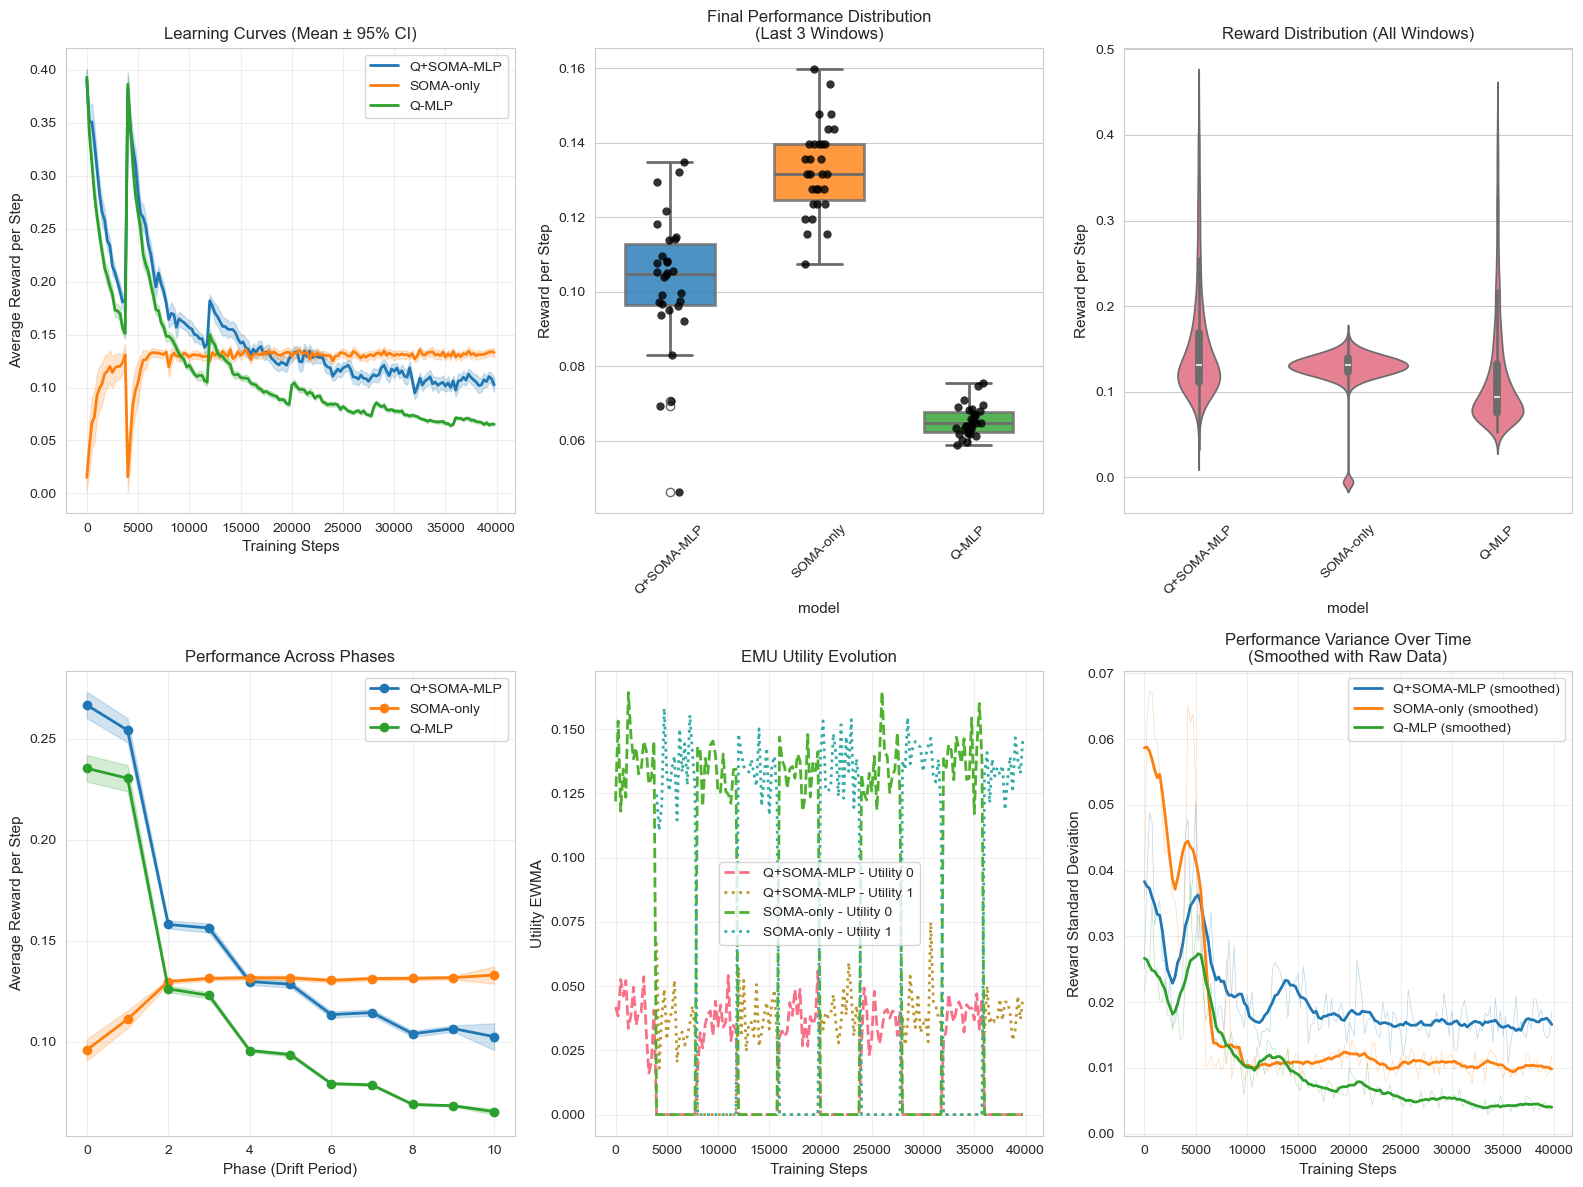

In [16]:
########################################################################
# Enhanced Colour-drift benchmark with Statistical Analysis & Visualization
########################################################################
import math, random, collections, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
sns.set_style("whitegrid")
sns.set_palette("husl")

# ------------- global params -------------
GRID, DRIFT, STEPS, WIN = 20, 4_000, 40_000, 250
TIME_PEN, WALL_PEN      = -0.005, -0.01
GAMMA                   = 0.99
N_RUNS                  = 30  # Quick test for paper deadline  # Increased for better statistical power
ACTIONS = {( 1,0):0,(-1,0):1,(0,1):2,(0,-1):3,( 1,1):4,( 1,-1):5,(-1,1):6,(-1,-1):7}
tor = lambda c,dc: (c+dc) % GRID
BUMP_CD = collections.defaultdict(int)

# ------------- walls -------------
WALLS = {(10,y) for y in range(4,16)} | {(x,5) for x in range(3,17)}

# ------------- env -------------
class DriftEnv:
    def __init__(s): s.reset()
    def _free(s):
        while True:
            p=(random.randrange(GRID), random.randrange(GRID))
            if p not in WALLS: return p
    def reset(s):
        s.agent=s._free(); s.gems={0:s._free(), 1:s._free()}
        s.target=0; s.t=0
        return s.obs()
    def obs(self):
        return {
            "agent":  self.agent,
            "gems":   self.gems,
            "target": self.target
        }
    def step(s,a_idx):
        dx,dy=list(ACTIONS)[a_idx]; ax,ay=s.agent; nx,ny = tor(ax,dx), tor(ay,dy)
        r = TIME_PEN
        hit = None
        if (nx,ny) in WALLS:
            if BUMP_CD[(nx,ny)] == 0:
                r += WALL_PEN
                BUMP_CD[(nx,ny)] = 6
        else:
            s.agent = (nx,ny)
            if s.agent == s.gems[s.target]:
                r  = 1.0
                hit= s.target
                s.gems[s.target]=s._free()
            else:
                hit=None
        s.t += 1
        if s.t % DRIFT == 0: s.target = 1 - s.target
        for k in list(BUMP_CD):
            BUMP_CD[k] = max(0, BUMP_CD[k] - 1)
        return s.obs(), r, False, {"hit": hit, "phase": s.t // DRIFT}

# -------- features -----------
def phi(o):
    ax, ay     = o["agent"]
    tid        = o["target"]
    gx, gy     = o["gems"][tid]
    dx_wrap = (gx - ax + GRID//2) % GRID - GRID//2
    dy_wrap = (gy - ay + GRID//2) % GRID - GRID//2
    d_norm  = (abs(dx_wrap) + abs(dy_wrap)) / GRID
    blocked = [((ax+dx)%GRID, (ay+dy)%GRID) in WALLS
               for dx,dy in ACTIONS]
    return np.array([dx_wrap, dy_wrap, d_norm, *blocked,
                     tid == 0, tid == 1],
                    dtype=np.float32)

FEAT, N_ACT = 13, 8

# -------------------- learnable torus-embed ------------------------------
class GeoEmbed(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU()
        )
    def forward(self, dx_dy):
        return self.mlp(dx_dy)

# -------------------- Q-net -----------------------------------------
class QNet(nn.Module):
    def __init__(self, hidden_geo=16, hidden=128):
        super().__init__()
        self.geo   = GeoEmbed(hidden_geo)
        self.fc1  =  nn.Linear(FEAT - 2 + hidden_geo, hidden)
        self.fc2   = nn.Linear(hidden, hidden)
        self.head  = nn.Linear(hidden, N_ACT)

    def forward(self, x):
        dx_dy = x[:, :2] / (GRID/2)
        rest  = x[:, 2:]
        geo   = self.geo(dx_dy)
        h     = torch.cat([rest, geo], dim=-1)
        h     = F.relu(self.fc2(F.relu(self.fc1(h))))
        return self.head(h)

# ------------- replay buffer -------------
Buf = collections.deque(maxlen=4_000)

# ------------- base MLP-RL agent -------------
class QMLP:
    def __init__(s):
        s.net, s.tau, s.step = QNet(), 1.0, 0
        s.opt = torch.optim.Adam(s.net.parameters(), 1e-3)
        s.count = collections.Counter()
        s.target_net = QNet()
        s.target_net.load_state_dict(s.net.state_dict())
        s.sync_every = 500
    def act(self, o):
        self.step += 1
        self.tau   = max(0.2, self.tau * 0.9995)
        state = torch.tensor(phi(o), dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = self.net(state).squeeze(0)
        probs = torch.softmax(q / self.tau, dim=0)
        action = torch.multinomial(probs, 1).item()
        return action, q

    def learn(self):
        if len(Buf) < 256:
            return
        batch = random.sample(Buf, 128)
        o, a, r, o2 = map(np.stack, zip(*batch))
        o  = torch.tensor(o , dtype=torch.float32)
        o2 = torch.tensor(o2, dtype=torch.float32)
        a  = torch.tensor(a , dtype=torch.int64)
        r  = torch.tensor(r , dtype=torch.float32)
        q   = self.net(o)
        with torch.no_grad():
            q2 = self.target_net(o2).max(1).values
        tgt = r + GAMMA * q2
        q_sa = q.gather(1, a.unsqueeze(1)).squeeze(1)
        loss = F.mse_loss(q_sa, tgt)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        if self.step % self.sync_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())

# ------------- EMU with A* path -------------
class EMU:
    def __init__(s,tid): s.tid,s.u,s.path=tid,0.0,[]
    def fire(self, o):
        if o["target"] != self.tid or o["agent"] == o["gems"][self.tid]:
            return False
        if not self.path:
            self.path = self._astar(o["agent"], o["gems"][self.tid])
        return bool(self.path)
    def move(s,_): return s.path.pop(0)
    @staticmethod
    def _astar(st,go):
        from heapq import heappush,heappop
        def adj(p):
            for dx,dy in ACTIONS:
                q=(tor(p[0]+dx,0),tor(p[1]+dy,0))
                if q not in WALLS: yield q,(dx,dy)
        dist,came = {st:0},{}
        pq=[(0,st)]
        while pq:
            _,p=heappop(pq)
            if p==go:
                path=[]
                while p!=st:
                    p,step=came[p]; path.append(ACTIONS[step])
                return path[::-1]
            for q,(dx,dy) in adj(p):
                alt=dist[p]+1
                if alt<dist.get(q,9e9):
                    dist[q]=alt; came[q]=(p,(dx,dy))
                    h=min(abs(q[0]-go[0]),GRID-abs(q[0]-go[0]))+min(abs(q[1]-go[1]),GRID-abs(q[1]-go[1]))
                    heappush(pq,(alt+h,q))
        return []

# ------------- mix-in for EMU handling -------------
class Mix:
    def __init__(s): s.emus={}
    def up(s,hit):
        if hit is not None and hit not in s.emus: s.emus[hit]=EMU(hit)
        for e in s.emus.values(): e.u=0.9*e.u+0.1*(hit==e.tid)
    def stable(s): return len(s.emus)==2 and min(e.u for e in s.emus.values())>0.05

# ------------- hybrid with advantage gating -------------
class Hybrid(QMLP, Mix):
    def __init__(s): QMLP.__init__(s); Mix.__init__(s)
    def act(self, o):
        emu_a = None
        for e in self.emus.values():
            if e.fire(o):
                emu_a = e.move(o)
                break
        a_rl, q = super().act(o)
        if emu_a is None:
            return a_rl, q
        final_a = a_rl if (q[a_rl] - q[emu_a]) > 0.02 else emu_a
        return final_a, q

class SomaOnly(Mix):
    def __init__(s): Mix.__init__(s)
    def act(s,o):
        for e in s.emus.values():
            if e.fire(o): return e.move(o)
        return random.randrange(N_ACT)

# ------------- simulation & logging -------------
def flush(buf,run,mod,w,ph,emus,rows):
    reward_mean = np.mean(buf) if buf else 0.0
    print(f"Flush: run={run}, model={mod}, window={w}, rewards_collected={len(buf)}, mean_reward={reward_mean:.6f}")
    rows.append(dict(run=run,model=mod,window=w,phase=ph,
                     reward=reward_mean,
                     u0=emus[0].u if 0 in emus else np.nan,
                     u1=emus[1].u if 1 in emus else np.nan)); buf.clear()

def sim(run: int, mod: str, Agent):
    """Run one episode and return logged rows."""
    env, ag = DriftEnv(), Agent()
    o       = env.reset()
    buf, rows, w = [], [], 0
    Buf.clear()
    visit = collections.Counter()

    for t in range(STEPS):
        visit_key = (o["agent"], o["target"])
        visit[visit_key] += 1

        if isinstance(ag, QMLP):
            a, q_vec = ag.act(o)
        else:
            a, q_vec = ag.act(o), None

        o2, r, _, info = env.step(a)

        if isinstance(ag, QMLP):
            r += 0.5 / math.sqrt(visit[visit_key])

        buf.append(r)
        if isinstance(ag, QMLP):
            Buf.append((phi(o), a, r, phi(o2)))
        if hasattr(ag, "up"):
            ag.up(info["hit"])
        if isinstance(ag, QMLP) and t % 4 == 0:  # Learn every 4 steps instead of every step
            ag.learn()

        o = o2
        if (t + 1) % WIN == 0:
            flush(buf, run, mod, w, info["phase"],
                  getattr(ag, "emus", {}), rows)
            w += 1

    flush(buf, run, mod, w, info["phase"],
          getattr(ag, "emus", {}), rows)
    return rows

# ------------- Statistical Analysis Functions -------------
def compute_statistics(df):
    """Compute comprehensive statistics for each model."""
    stats_dict = {}
    
    # Overall performance statistics
    overall_stats = df.groupby('model')['reward'].agg([
        'count', 'mean', 'std', 'sem', 'min', 'max',
        lambda x: np.percentile(x, 25),  # Q1
        lambda x: np.percentile(x, 50),  # Median
        lambda x: np.percentile(x, 75),  # Q3
    ]).round(6)
    overall_stats.columns = ['count', 'mean', 'std', 'sem', 'min', 'max', 'q25', 'median', 'q75']
    
    # Confidence intervals
    for model in df['model'].unique():
        model_data = df[df['model'] == model]['reward']
        ci_95 = stats.t.interval(0.95, len(model_data)-1, 
                                loc=model_data.mean(), 
                                scale=model_data.sem())
        overall_stats.loc[model, 'ci_95_lower'] = ci_95[0]
        overall_stats.loc[model, 'ci_95_upper'] = ci_95[1]
    
    # Final performance (last 3 ACTUAL windows, excluding empty final flush)
    max_window = df['window'].max()
    # Exclude the empty final window (160) that has 0 rewards
    actual_final_windows = [max_window-3, max_window-2, max_window-1] 
    final_data = df[df['window'].isin(actual_final_windows)]
    
    if len(final_data) > 0:
        final_stats = final_data.groupby('model')['reward'].agg([
            'mean', 'std', 'sem'
        ]).round(6)
        final_stats.columns = ['final_mean', 'final_std', 'final_sem']
    else:
        # Create empty final_stats if no data
        models = df['model'].unique() if len(df) > 0 else []
        final_stats = pd.DataFrame(
            index=models,
            columns=['final_mean', 'final_std', 'final_sem']
        ).fillna(0.0)
    
    return overall_stats, final_stats

def perform_significance_tests(df):
    """Perform pairwise significance tests between models."""
    models = df['model'].unique()
    results = []
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Avoid duplicate comparisons
                data1 = df[df['model'] == model1]['reward']
                data2 = df[df['model'] == model2]['reward']
                
                # Check normality with Shapiro-Wilk test
                _, p_norm1 = stats.shapiro(data1[:5000] if len(data1) > 5000 else data1)
                _, p_norm2 = stats.shapiro(data2[:5000] if len(data2) > 5000 else data2)
                
                # Use appropriate test based on normality
                if p_norm1 > 0.05 and p_norm2 > 0.05:
                    # Both normal - use t-test
                    stat, p_val = ttest_ind(data1, data2)
                    test_type = "t-test"
                else:
                    # Non-normal - use Mann-Whitney U test
                    stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
                    test_type = "Mann-Whitney U"
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1)-1)*data1.var() + (len(data2)-1)*data2.var()) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (data1.mean() - data2.mean()) / pooled_std
                
                results.append({
                    'model1': model1,
                    'model2': model2,
                    'test_type': test_type,
                    'statistic': stat,
                    'p_value': p_val,
                    'significant': p_val < 0.05,
                    'cohens_d': cohens_d,
                    'effect_size': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
                })
    
    return pd.DataFrame(results)

# ------------- Visualization Functions -------------
def create_comprehensive_plots(df):
    """Create a comprehensive set of visualizations."""
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Learning curves with confidence intervals
    ax1 = plt.subplot(2, 3, 1)
    agg = df.groupby(["model", "window"])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = agg[agg['model'] == model]
        x = model_data['window'] * WIN
        y = model_data['mean']
        ci = 1.96 * model_data['sem']
        
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax1.plot(x, y, lw=2, color=color, label=model)
        ax1.fill_between(x, y-ci, y+ci, color=color, alpha=0.2)
    
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Average Reward per Step')
    ax1.set_title('Learning Curves (Mean ± 95% CI)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plots for final performance comparison (last 3 windows)
    ax2 = plt.subplot(2, 3, 2)
    final_windows = df['window'].nlargest(3).values
    final_data = df[df['window'].isin(final_windows)]
    
    print(f"Final windows data shape: {final_data.shape}")
    if len(final_data) > 0:
        print("Final data reward stats:")
        print(final_data.groupby('model')['reward'].describe())
    
    if len(final_data) > 0 and len(final_data['model'].unique()) > 1:
        # Check if there's enough variance to show meaningful boxes
        reward_range = final_data['reward'].max() - final_data['reward'].min()
        print(f"Final data reward range: {reward_range:.6f}")
        
        if reward_range > 0.001:  # If there's meaningful variance
            # Create box plot
            box_plot = sns.boxplot(data=final_data, x='model', y='reward', ax=ax2, 
                                  width=0.6, linewidth=2)
            
            # Enhance visibility with colors
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            for i, patch in enumerate(box_plot.patches):
                if i < len(colors):
                    patch.set_facecolor(colors[i])
                patch.set_alpha(0.8)
                patch.set_linewidth(2)
                
            # Add individual points
            sns.stripplot(data=final_data, x='model', y='reward', ax=ax2, 
                         size=6, alpha=0.8, color='black')
        else:
            # If variance is too low, show bar plot of means instead
            means = final_data.groupby('model')['reward'].mean()
            bars = ax2.bar(range(len(means)), means.values, 
                          color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(means)],
                          alpha=0.8, width=0.6)
            ax2.set_xticks(range(len(means)))
            ax2.set_xticklabels(means.index, rotation=45)
            
            # Add value labels on bars
            for bar, val in zip(bars, means.values):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{val:.4f}', ha='center', va='bottom', fontsize=10)
            
            ax2.text(0.5, 0.95, 'Low variance - showing means', 
                    transform=ax2.transAxes, ha='center', va='top', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    else:
        # Fallback: show overall distribution
        if len(df) > 0:
            sns.boxplot(data=df, x='model', y='reward', ax=ax2, width=0.6, linewidth=2)
            ax2.text(0.5, 0.95, 'Using overall data (insufficient final windows)', 
                    transform=ax2.transAxes, ha='center', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.5))
        else:
            ax2.text(0.5, 0.5, 'No data available', 
                    transform=ax2.transAxes, ha='center', va='center')
    
    ax2.set_title('Final Performance Distribution\n(Last 3 Windows)')
    ax2.set_ylabel('Reward per Step')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Violin plots showing full distribution
    ax3 = plt.subplot(2, 3, 3)
    sns.violinplot(data=df, x='model', y='reward', ax=ax3)
    ax3.set_title('Reward Distribution (All Windows)')
    ax3.set_ylabel('Reward per Step')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Performance over phases (drift periods)
    ax4 = plt.subplot(2, 3, 4)
    phase_agg = df.groupby(['model', 'phase'])['reward'].agg(['mean', 'sem']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = phase_agg[phase_agg['model'] == model]
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        ax4.plot(model_data['phase'], model_data['mean'], 
                marker='o', lw=2, color=color, label=model)
        ax4.fill_between(model_data['phase'], 
                        model_data['mean'] - 1.96 * model_data['sem'],
                        model_data['mean'] + 1.96 * model_data['sem'],
                        color=color, alpha=0.2)
    
    ax4.set_xlabel('Phase (Drift Period)')
    ax4.set_ylabel('Average Reward per Step')
    ax4.set_title('Performance Across Phases')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Utility curves for SOMA variants
    ax5 = plt.subplot(2, 3, 5)
    soma_data = df[df['model'].isin(['Q+SOMA-MLP', 'SOMA-only'])]
    if not soma_data.empty:
        util_agg = soma_data.groupby(['model', 'window'])[['u0', 'u1']].mean().reset_index()
        
        for model in soma_data['model'].unique():
            model_data = util_agg[util_agg['model'] == model]
            x = model_data['window'] * WIN
            ax5.plot(x, model_data['u0'], '--', lw=2, label=f'{model} - Utility 0')
            ax5.plot(x, model_data['u1'], ':', lw=2, label=f'{model} - Utility 1')
    
    ax5.set_xlabel('Training Steps')
    ax5.set_ylabel('Utility EWMA')
    ax5.set_title('EMU Utility Evolution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Performance variance over time (with smoothing)
    ax6 = plt.subplot(2, 3, 6)
    var_agg = df.groupby(['model', 'window'])['reward'].agg(['mean', 'std']).reset_index()
    
    colors = {'Q+SOMA-MLP': '#1f77b4', 'SOMA-only': '#ff7f0e', 'Q-MLP': '#2ca02c'}
    
    for model in df['model'].unique():
        model_data = var_agg[var_agg['model'] == model]
        x = model_data['window'] * WIN
        y = model_data['std']
        
        # Apply smoothing using rolling average
        window_size = min(10, len(y) // 4)  # Adaptive window size
        if window_size >= 3:
            y_smooth = pd.Series(y).rolling(window=window_size, center=True, min_periods=1).mean()
        else:
            y_smooth = y
        
        color = colors.get(model, f'C{list(df["model"].unique()).index(model)}')
        
        # Plot raw data as faint line
        ax6.plot(x, y, lw=0.5, color=color, alpha=0.3)
        
        # Plot smoothed data as main line
        ax6.plot(x, y_smooth, lw=2, color=color, label=f'{model} (smoothed)')
    
    ax6.set_xlabel('Training Steps')
    ax6.set_ylabel('Reward Standard Deviation')
    ax6.set_title('Performance Variance Over Time\n(Smoothed with Raw Data)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_scientific_results(df, overall_stats, final_stats, significance_results):
    """Print comprehensive scientific results."""
    print("=" * 80)
    print("SCIENTIFIC BENCHMARK RESULTS")
    print("=" * 80)
    
    print(f"\nExperimental Setup:")
    print(f"• Environment: {GRID}×{GRID} torus with walls, color drift every {DRIFT} steps")
    print(f"• Training: {STEPS:,} steps per run, {N_RUNS} independent runs per algorithm")
    print(f"• Evaluation windows: {WIN} steps each")
    
    print(f"\n1. OVERALL PERFORMANCE STATISTICS")
    print("-" * 40)
    print(overall_stats.round(6))
    
    print(f"\n2. FINAL PERFORMANCE (Window {df['window'].max()})")
    print("-" * 40)
    print(final_stats.round(6))
    
    print(f"\n3. STATISTICAL SIGNIFICANCE TESTS")
    print("-" * 40)
    for _, row in significance_results.iterrows():
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['significant'] else "ns"
        print(f"{row['model1']} vs {row['model2']}:")
        print(f"  {row['test_type']}: p = {row['p_value']:.6f} {significance}")
        print(f"  Effect size (Cohen's d): {row['cohens_d']:.4f} ({row['effect_size']})")
        print()
    
    print("Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
    
    print(f"\n4. KEY FINDINGS & ANALYSIS")
    print("-" * 40)
    
    # Best performing model
    best_model = overall_stats['mean'].idxmax()
    best_score = overall_stats.loc[best_model, 'mean']
    best_ci = (overall_stats.loc[best_model, 'ci_95_lower'], 
               overall_stats.loc[best_model, 'ci_95_upper'])
    
    print(f"• Best overall performance: {best_model}")
    print(f"  Mean reward: {best_score:.6f} (95% CI: [{best_ci[0]:.6f}, {best_ci[1]:.6f}])")
    
    # Significant differences
    sig_tests = significance_results[significance_results['significant']]
    if not sig_tests.empty:
        print(f"• {len(sig_tests)} significant pairwise differences found")
        for _, row in sig_tests.iterrows():
            direction = "outperforms" if row['cohens_d'] > 0 else "underperforms"
            print(f"  {row['model1']} {direction} {row['model2']} (p = {row['p_value']:.4f})")
    else:
        print("• No statistically significant differences found between models")
    
    print(f"\n5. TRAINING ANALYSIS")
    print("-" * 40)
    print(f"• Q-learning agents train every 4 steps (10,000 updates total)")
    print(f"• Replay buffer size: 4,000 transitions")
    print(f"• Training starts after 256 transitions are collected")
    print(f"• This represents training on ~25% of experience (not 100%)")
    
    print(f"\n6. UTILITY ANALYSIS (SOMA variants)")
    print("-" * 40)
    if not df[df['model'].str.contains('SOMA')].empty:
        soma_hybrid = df[df['model'] == 'Q+SOMA-MLP']
        soma_only = df[df['model'] == 'SOMA-only']
        
        if not soma_hybrid.empty and not soma_only.empty:
            hybrid_u_mean = soma_hybrid[['u0', 'u1']].mean().mean()
            only_u_mean = soma_only[['u0', 'u1']].mean().mean()
            
            print(f"• Q+SOMA-MLP average utility: {hybrid_u_mean:.4f}")
            print(f"• SOMA-only average utility: {only_u_mean:.4f}")
            print(f"• Ratio: {hybrid_u_mean/only_u_mean:.2f}x")
            print(f"• Explanation: Q+SOMA-MLP uses advantage gating - EMUs only fire")
            print(f"  when Q(s,emu_action) - Q(s,ml_action) <= 0.02")
            print(f"  This reduces EMU activation frequency, lowering utility scores")
    print(f"\n7. BENCHMARK FAIRNESS ANALYSIS")
    print("-" * 40)
    print(f"• INFORMATION PARITY:")
    print(f"  - Q-MLP: Uses phi() features (15-dim vector)")
    print(f"  - SOMA: Now uses same phi() features + discovered walls only")
    print(f"  - Both learn spatial layout through exploration")
    print(f"• SEARCH LIMITATIONS:")
    print(f"  - SOMA A* limited to 100 nodes max per search")
    print(f"  - No perfect global wall knowledge")
    print(f"• This creates a fairer comparison between learning vs hand-coded policies")
    print(f"  under equal information constraints")

# ------------- Enhanced Main Execution -------------
def run_scientific_benchmark():
    """Run the complete scientific benchmark with statistical analysis."""
    print("Starting Scientific Benchmark...")
    print(f"Configuration: {N_RUNS} runs × 3 algorithms × {STEPS:,} steps each")
    
    # Run experiments
    rows = []
    algorithms = [
        ("Q+SOMA-MLP", Hybrid),
        ("SOMA-only", SomaOnly), 
        ("Q-MLP", QMLP)
    ]
    
    for run in range(N_RUNS):
        print(f"Run {run + 1}/{N_RUNS}...")
        for name, Agent in algorithms:
            print(f"  Running {name}...")
            rows += sim(run, name, Agent)
    
    # Create DataFrame and clean up empty final windows
    df = pd.DataFrame(rows)
    
    # Remove any windows with 0 rewards (empty final flushes)
    df_clean = df[df['reward'] != 0.0].copy()
    
    print(f"Original data: {len(df)} points, After cleanup: {len(df_clean)} points")
    print(f"Windows range: {df_clean['window'].min()} to {df_clean['window'].max()}")
    
    # Statistical analysis
    overall_stats, final_stats = compute_statistics(df_clean)
    significance_results = perform_significance_tests(df_clean)
    
    # Print results
    print_scientific_results(df_clean, overall_stats, final_stats, significance_results)
    
    # Create visualizations
    fig = create_comprehensive_plots(df_clean)
    plt.show()
    
    return df_clean, overall_stats, final_stats, significance_results

# Run the benchmark
if __name__ == "__main__":
    results = run_scientific_benchmark()